In [1]:
import pickle
from shapely.geometry import Point
import matplotlib.pyplot as plt
import geopandas
from pathlib import Path
from ripe.atlas.cousteau import AtlasRequest
from ripe.atlas.sagan import PingResult
from collections import namedtuple
from datetime import timezone
import csv
import pandas as pd
import numpy as np
import datetime
from zoneinfo import ZoneInfo
from fitter import Fitter

In [2]:
with open('pickle-files/measurements_by_anchor_id_dump.pickle', 'rb') as file_handle:
    measurements_by_anchor_id = pickle.load(file_handle)

chosen_anchors = [1135, 1819, 1293, 2494, 1922]
chosen_probes = [6348, 6031, 6220, 7139, 6082, 6955, 6932, 6969, 7188, 6661]
measurements_corresponding_to_chosen_anchors = [9333345, 22422574, 16453122, 29724243, 23062801]
regions_corresponding_to_chosen_anchors = [1, 3, 9, 17, 21]

# 6348 (region 3 changed to 1), 6661 (region 17 changed to 21)
regions_corresponding_to_chosen_probes = [1, 3, 7, 9, 10, 12, 16, 17, 18, 21] 

measurements_corresponding_to_chosen_anchors_with_api_responses = {}

for anchor_id in chosen_anchors:
    for measurement in measurements_by_anchor_id[anchor_id]["results"]:
        if measurement["id"] in measurements_corresponding_to_chosen_anchors:
            measurements_corresponding_to_chosen_anchors_with_api_responses[measurement["id"]] = measurement

In [6]:
# Open selected probes API information

with open('pickle-files/probes_from_measurements_of_anchors_with_coverage_10_or_more_areas.pickle', 'rb') as file_handle:
    probes_from_measurements_of_anchors_with_coverage_10_or_more_areas = pickle.load(file_handle)

In [6]:
"""
Print API response information about chosen measurements

Interval - The number of seconds each probe participating in the measurement will wait before attempting to perform the measurement again.
Packets - The number of packets that should be sent in each ping.
""" 

for measurement_id in measurements_corresponding_to_chosen_anchors_with_api_responses:
    creation_time = datetime.datetime.utcfromtimestamp(measurements_corresponding_to_chosen_anchors_with_api_responses[measurement_id]["creation_time"])
    start_time = datetime.datetime.utcfromtimestamp(measurements_corresponding_to_chosen_anchors_with_api_responses[measurement_id]["start_time"])
    stop_time_timestamp = measurements_corresponding_to_chosen_anchors_with_api_responses[measurement_id]["stop_time"]
    stop_time = "no"
    if stop_time_timestamp:
        stop_time = datetime.datetime.utcromtimestamp(stop_time_timestamp)

    interval_in_minutes = measurements_corresponding_to_chosen_anchors_with_api_responses[measurement_id]["interval"] / 60
    packets_per_ping = measurements_corresponding_to_chosen_anchors_with_api_responses[measurement_id]["packets"]
    print(f"Measurement {measurement_id} created {creation_time}, started {start_time}, ended {stop_time}, time interval: {interval_in_minutes} minutes, packets per ping: {packets_per_ping}")


print("\n******************************************************************************\n")

for probe_id in chosen_probes:
    probe_api_response = probes_from_measurements_of_anchors_with_coverage_10_or_more_areas[probe_id]
    first_connected = datetime.datetime.utcfromtimestamp(probe_api_response["first_connected"])
    last_connected = datetime.datetime.utcfromtimestamp(probe_api_response["last_connected"])
    print(f"Probe {probe_id} first connected: {first_connected}, last connected: {last_connected}")

Measurement 9333345 created 2017-09-25 08:12:44, started 2017-09-25 08:12:44, ended no, time interval: 4.0 minutes, packets per ping: 3
Measurement 22422574 created 2019-07-24 20:34:53, started 2019-07-24 20:34:53, ended no, time interval: 4.0 minutes, packets per ping: 3
Measurement 16453122 created 2018-10-10 08:43:32, started 2018-10-10 08:43:32, ended no, time interval: 4.0 minutes, packets per ping: 3
Measurement 29724243 created 2021-04-19 00:33:43, started 2021-04-19 00:33:43, ended no, time interval: 4.0 minutes, packets per ping: 3
Measurement 23062801 created 2019-10-11 18:48:48, started 2019-10-11 18:48:47, ended no, time interval: 4.0 minutes, packets per ping: 3

******************************************************************************

Probe 6348 first connected: 2018-03-15 13:41:36, last connected: 2023-06-29 13:05:28
Probe 6031 first connected: 2013-12-19 13:30:32, last connected: 2023-06-29 13:05:29
Probe 6220 first connected: 2016-09-17 09:54:35, last connected: 

In [10]:
def get_api(url_path):
    request = AtlasRequest(**{"url_path": url_path})
    result = namedtuple('Result', 'success response')
    (result.success, result.response) = request.get()
    if not result.success:
        print(result)
        return False

    return result.response

In [34]:
# Create headers for CSV files

csv_header_summary_stats = "StartTime,EndTime"
metrics = ["NumSamples_", "RTT_MIN_", "RTT_AVG_", "RTT_MAX_", "RTT_Q1_", "RTT_MEDIAN_", "RTT_Q3_"]

for i in range(len(chosen_probes)):
    for metric in metrics:
        csv_header_summary_stats +=  "," + metric + str(regions_corresponding_to_chosen_probes[i]) 

# Put NumSamples last so that there is no need to go over ping_results again 
csv_header_individual_rtts = "StartTime,EndTime,RegionId"
for i in range(1, 13):
    csv_header_individual_rtts += f",RTT_{i}"
csv_header_individual_rtts += ",NumSamples"

In [11]:
# Get RTT values 
# Save min, mean, max, q1, median, q3

def get_measurement_values(original_start_time, complete_end_time):
    for measurement_id in measurements_corresponding_to_chosen_anchors:
        index = measurements_corresponding_to_chosen_anchors.index(measurement_id)
        print(f"Measurement ID {measurement_id}")
        start_time = original_start_time
        start_timestamp = int(start_time.timestamp())
        end_time = start_time

        csv_string_summary_stats = csv_header_summary_stats
        csv_string_individual_rtts = csv_header_individual_rtts
        while end_time < complete_end_time:
            end_time = start_time + datetime.timedelta(minutes=15)
            end_timestamp = int(end_time.timestamp())

            csv_string_summary_stats += f"\n{start_timestamp},{end_timestamp}"

            for probe_index, probe_id in enumerate(chosen_probes):
                csv_string_individual_rtts += f"\n{start_timestamp},{end_timestamp},{regions_corresponding_to_chosen_probes[probe_index]}"
                api_response = get_api(f"/api/v2/measurements/{measurement_id}/results/?start={start_timestamp}&stop={end_timestamp}&probe_ids={probe_id}")

                ping_results = []
                try:
                    index_of_rtt_value = 0
                    for sample in api_response:
                        ping_result = PingResult(sample)
                        for packet in ping_result.packets:
                            if packet.rtt:
                                ping_results.append(packet.rtt)
                                csv_string_individual_rtts += f",{packet.rtt}"
                            else:
                                csv_string_individual_rtts += f",NaN"
                            index_of_rtt_value += 1

                    if index_of_rtt_value < 12:
                        for i in range(index_of_rtt_value, 12):
                            csv_string_individual_rtts += f",NaN"

                    if index_of_rtt_value > 12:
                        print(f"API response returned {index_of_rtt_value} RTT results instead of 12.")

                    num_samples = len(ping_results)
                    average_rtt = 0
                    max_rtt = 0
                    min_rtt = 0
                    q1, median, q3 = 0, 0, 0

                    if num_samples > 0:
                        try:
                            average_rtt = np.mean(ping_results)
                            max_rtt = np.max(ping_results)
                            min_rtt = np.min(ping_results)
                            q1, median, q3 = np.quantile(ping_results, [0.25, 0.5, 0.75])
                        except Exception as e:
                            print(f"Exception {e} with np.mean for probe_id {probe_id} and {ping_results}")

                except Exception as e:
                    print(f"Exception {e} when processing API response {api_response}")
                csv_string_summary_stats += f",{num_samples},{min_rtt},{average_rtt},{max_rtt},{q1},{median},{q3}"
                csv_string_individual_rtts += f",{num_samples}"

            start_time = end_time
            start_timestamp = int(start_time.timestamp())

        print(f"Measurement {measurement_id} finished: {original_start_time}, {end_time}")
        with open(f"measurement-results-new/regionid{regions_corresponding_to_chosen_anchors[index]}_start{original_start_time.strftime('%Y-%m-%d-%H-%M')}_end{complete_end_time.strftime('%Y-%m-%d-%H-%M')}.csv", "a") as f:
            f.write(csv_string_summary_stats)

        with open(f"measurement-results-individual-rtts/regionid{regions_corresponding_to_chosen_anchors[index]}_start{original_start_time.strftime('%Y-%m-%d-%H-%M')}_end{complete_end_time.strftime('%Y-%m-%d-%H-%M')}.csv", "a") as f:
            f.write(csv_string_individual_rtts)

In [11]:
def create_datetime_object(time_interval):
    start = datetime.datetime.strptime(time_interval[0], "%Y-%m-%d %H:%M:%S%z")
    end = datetime.datetime.strptime(time_interval[1], "%Y-%m-%d %H:%M:%S%z")
    return start, end

In [13]:
# First 3 contain area 7, last 3 areas 9 and 18

time_intervals_15_minutes = [
    ["2021-05-20 10:00:00+0000","2021-05-20 10:15:00+0000"],
    ["2021-06-20 10:00:00+0000","2021-06-20 10:15:00+0000"],
    ["2021-07-20 10:00:00+0000","2021-07-20 10:15:00+0000"],
    ["2023-04-20 10:00:00+0000","2023-04-20 10:15:00+0000"],
    ["2023-05-20 10:00:00+0000","2023-05-20 10:15:00+0000"],
    ["2023-06-20 10:00:00+0000","2023-06-20 10:15:00+0000"],
]

for time_interval in time_intervals_15_minutes:
    start, end = create_datetime_object(time_interval)
    get_measurement_values(start, end)

Measurement ID 9333345
Measurement 9333345 finished: 2021-05-20 10:00:00+00:00, 2021-05-20 10:15:00+00:00
Measurement ID 22422574
Measurement 22422574 finished: 2021-05-20 10:00:00+00:00, 2021-05-20 10:15:00+00:00
Measurement ID 16453122
Measurement 16453122 finished: 2021-05-20 10:00:00+00:00, 2021-05-20 10:15:00+00:00
Measurement ID 29724243
Measurement 29724243 finished: 2021-05-20 10:00:00+00:00, 2021-05-20 10:15:00+00:00
Measurement ID 23062801
Measurement 23062801 finished: 2021-05-20 10:00:00+00:00, 2021-05-20 10:15:00+00:00
Measurement ID 9333345
Measurement 9333345 finished: 2021-06-20 10:00:00+00:00, 2021-06-20 10:15:00+00:00
Measurement ID 22422574
Measurement 22422574 finished: 2021-06-20 10:00:00+00:00, 2021-06-20 10:15:00+00:00
Measurement ID 16453122
Measurement 16453122 finished: 2021-06-20 10:00:00+00:00, 2021-06-20 10:15:00+00:00
Measurement ID 29724243
Measurement 29724243 finished: 2021-06-20 10:00:00+00:00, 2021-06-20 10:15:00+00:00
Measurement ID 23062801
Measurem

In [21]:
columns_regions_corresponding_to_probes = [f"Region {region_id}" for region_id in regions_corresponding_to_chosen_probes]
rows_regions_corresponding_to_anchors = [f"Region {region_id}" for region_id in regions_corresponding_to_chosen_anchors]

def print_summary_stats_tables(time_intervals, missing_regions):
    for time_interval in time_intervals:
        start, end = create_datetime_object(time_interval)
        mean_rtt_table = pd.DataFrame(columns=columns_regions_corresponding_to_probes, index=rows_regions_corresponding_to_anchors) 
        median_rtt_table = pd.DataFrame(columns=columns_regions_corresponding_to_probes, index=rows_regions_corresponding_to_anchors)
        max_rtt_table = pd.DataFrame(columns=columns_regions_corresponding_to_probes, index=rows_regions_corresponding_to_anchors)
        min_rtt_table = pd.DataFrame(columns=columns_regions_corresponding_to_probes, index=rows_regions_corresponding_to_anchors)

        for anchor_region in regions_corresponding_to_chosen_anchors:
            c = pd.read_csv(f"measurement-results-new/regionid{anchor_region}_start{format(start, '%Y-%m-%d-%H-%M')}_end{format(end, '%Y-%m-%d-%H-%M')}.csv")

            for probe_region in regions_corresponding_to_chosen_probes:
                rtt_value = round(c[f"RTT_AVG_{probe_region}"].values[0], 3)
                median_value = round(c[f"RTT_MEDIAN_{probe_region}"].values[0], 3)
                max_value = round(c[f"RTT_MAX_{probe_region}"].values[0], 3)
                min_value = round(c[f"RTT_MIN_{probe_region}"].values[0], 3)

                if probe_region in missing_regions:
                    rtt_value = "x"
                    median_value = "x"
                    max_value = "x"
                    min_value = "x"

                mean_rtt_table.loc[f"Region {anchor_region}", f"Region {probe_region}"] = rtt_value
                median_rtt_table.loc[f"Region {anchor_region}", f"Region {probe_region}"] = median_value
                max_rtt_table.loc[f"Region {anchor_region}", f"Region {probe_region}"] = max_value
                min_rtt_table.loc[f"Region {anchor_region}", f"Region {probe_region}"] = min_value

        print(f"------------Time period {start} - {end}---------------------\n")
        print(f"Mean RTT values")
        display(mean_rtt_table)
        print(f"Median RTT values")
        display(median_rtt_table)
        print(f"Max RTT values")
        display(max_rtt_table)
        print(f"Min RTT values")
        display(min_rtt_table)

In [16]:
time_intervals_15_minutes = [
    ["2021-05-20 10:00:00+0000","2021-05-20 10:15:00+0000"],
    ["2021-06-20 10:00:00+0000","2021-06-20 10:15:00+0000"],
    ["2021-07-20 10:00:00+0000","2021-07-20 10:15:00+0000"],
    ["2023-04-20 10:00:00+0000","2023-04-20 10:15:00+0000"],
    ["2023-05-20 10:00:00+0000","2023-05-20 10:15:00+0000"],
    ["2023-06-20 10:00:00+0000","2023-06-20 10:15:00+0000"],
]

In [22]:
print_summary_stats_tables(time_intervals_15_minutes[:3], [9, 18])

print_summary_stats_tables(time_intervals_15_minutes[3:], [7])

------------Time period 2021-05-20 10:00:00+00:00 - 2021-05-20 10:15:00+00:00---------------------

Mean RTT values


,Region 1,Region 3,Region 7,Region 9,Region 10,Region 12,Region 16,Region 17,Region 18,Region 21
Region 1,0.426,1.334,2.826,x,2.239,1.206,1.714,2.483,x,0.854
Region 3,1.15,1.151,2.639,x,1.513,1.586,1.489,1.398,x,1.044
Region 9,2.541,18.463,19.429,x,1.587,1.439,1.704,16.771,x,18.075
Region 17,1.01,1.239,1.851,x,1.152,0.796,1.308,0.555,x,0.467
Region 21,0.977,1.297,1.634,x,1.424,1.218,1.234,0.812,x,0.881


Median RTT values


,Region 1,Region 3,Region 7,Region 9,Region 10,Region 12,Region 16,Region 17,Region 18,Region 21
Region 1,0.402,1.131,2.758,x,2.166,1.144,1.704,2.464,x,0.859
Region 3,1.142,1.16,2.638,x,1.482,1.592,1.504,1.412,x,1.004
Region 9,1.555,18.449,19.368,x,1.559,1.424,1.657,16.778,x,18.051
Region 17,0.998,1.158,1.772,x,1.13,0.756,1.286,0.528,x,0.466
Region 21,0.976,1.282,1.616,x,1.464,1.16,1.188,0.814,x,0.843


Max RTT values


,Region 1,Region 3,Region 7,Region 9,Region 10,Region 12,Region 16,Region 17,Region 18,Region 21
Region 1,0.769,1.958,3.236,x,2.529,1.494,1.889,2.813,x,1.186
Region 3,1.3,1.236,2.783,x,1.657,1.775,1.617,1.502,x,1.242
Region 9,10.401,18.666,19.946,x,1.789,1.574,1.83,16.913,x,18.176
Region 17,1.169,2.078,2.484,x,1.312,1.125,1.459,0.935,x,0.556
Region 21,1.098,2.016,1.921,x,1.646,1.878,1.516,0.893,x,1.192


Min RTT values


,Region 1,Region 3,Region 7,Region 9,Region 10,Region 12,Region 16,Region 17,Region 18,Region 21
Region 1,0.298,1.01,2.649,x,2.065,1.072,1.609,2.278,x,0.633
Region 3,1.006,1.068,2.491,x,1.396,1.43,1.305,1.277,x,0.865
Region 9,1.457,18.375,19.193,x,1.423,1.314,1.602,16.656,x,18.012
Region 17,0.933,1.009,1.658,x,1.046,0.665,1.238,0.388,x,0.359
Region 21,0.861,0.856,1.471,x,1.109,1.067,1.07,0.728,x,0.744


------------Time period 2021-06-20 10:00:00+00:00 - 2021-06-20 10:15:00+00:00---------------------

Mean RTT values


,Region 1,Region 3,Region 7,Region 9,Region 10,Region 12,Region 16,Region 17,Region 18,Region 21
Region 1,0.494,1.114,2.879,x,2.434,1.195,1.897,2.552,x,0.691
Region 3,1.099,1.094,2.595,x,1.592,1.587,1.55,1.474,x,0.99
Region 9,1.472,18.556,10.86,x,1.628,5.251,1.797,15.406,x,15.319
Region 17,1.763,1.164,2.054,x,1.207,0.737,1.524,0.569,x,0.506
Region 21,0.983,1.203,1.706,x,1.193,4.914,1.196,0.735,x,0.877


Median RTT values


,Region 1,Region 3,Region 7,Region 9,Region 10,Region 12,Region 16,Region 17,Region 18,Region 21
Region 1,0.408,1.011,2.862,x,2.221,1.102,1.822,2.582,x,0.659
Region 3,1.114,1.088,2.587,x,1.584,1.606,1.544,1.504,x,0.973
Region 9,1.469,18.47,10.742,x,1.64,5.205,1.796,15.398,x,15.333
Region 17,0.954,1.144,1.821,x,1.126,0.69,1.525,0.542,x,0.493
Region 21,0.897,1.187,1.593,x,1.202,4.761,1.157,0.721,x,0.868


Max RTT values


,Region 1,Region 3,Region 7,Region 9,Region 10,Region 12,Region 16,Region 17,Region 18,Region 21
Region 1,0.951,1.455,3.188,x,4.363,1.6,2.598,2.909,x,0.949
Region 3,1.268,1.196,2.753,x,1.775,1.72,1.739,1.576,x,1.265
Region 9,1.551,19.176,11.262,x,1.715,5.616,1.879,15.517,x,15.393
Region 17,10.891,1.35,3.44,x,1.52,1.213,1.687,0.806,x,0.597
Region 21,1.318,1.448,2.714,x,1.311,6.177,1.494,0.986,x,1.033


Min RTT values


,Region 1,Region 3,Region 7,Region 9,Region 10,Region 12,Region 16,Region 17,Region 18,Region 21
Region 1,0.309,0.927,2.565,x,2.096,0.916,1.603,2.275,x,0.498
Region 3,0.969,0.991,2.439,x,1.414,1.399,1.443,1.324,x,0.819
Region 9,1.405,18.289,10.651,x,1.534,5.04,1.73,15.333,x,15.23
Region 17,0.853,1.038,1.736,x,1.062,0.616,1.413,0.427,x,0.414
Region 21,0.835,0.94,1.466,x,1.081,4.602,0.984,0.612,x,0.75


------------Time period 2021-07-20 10:00:00+00:00 - 2021-07-20 10:15:00+00:00---------------------

Mean RTT values


,Region 1,Region 3,Region 7,Region 9,Region 10,Region 12,Region 16,Region 17,Region 18,Region 21
Region 1,0.462,1.737,3.098,x,2.226,1.069,1.953,2.753,x,0.681
Region 3,1.241,1.098,3.035,x,1.607,1.397,1.548,1.386,x,1.039
Region 9,1.617,18.406,12.157,x,1.627,2.091,1.795,9.617,x,18.142
Region 17,0.906,1.148,1.842,x,1.448,0.83,1.72,0.686,x,0.532
Region 21,0.939,1.288,2.037,x,1.344,1.987,1.454,1.001,x,0.91


Median RTT values


,Region 1,Region 3,Region 7,Region 9,Region 10,Region 12,Region 16,Region 17,Region 18,Region 21
Region 1,0.444,1.306,2.904,x,2.022,0.983,1.946,2.73,x,0.664
Region 3,1.172,1.074,3.096,x,1.595,1.372,1.552,1.386,x,1.038
Region 9,1.502,18.396,12.135,x,1.55,2.092,1.78,9.616,x,18.127
Region 17,0.911,1.102,1.781,x,1.13,0.73,1.664,0.61,x,0.508
Region 21,0.932,1.108,1.649,x,1.224,1.923,1.461,0.945,x,0.864


Max RTT values


,Region 1,Region 3,Region 7,Region 9,Region 10,Region 12,Region 16,Region 17,Region 18,Region 21
Region 1,0.707,7.108,4.635,x,3.824,1.395,2.252,3.154,x,0.965
Region 3,1.925,1.312,3.138,x,1.787,1.553,1.714,1.575,x,1.12
Region 9,2.63,18.532,12.336,x,1.946,2.162,1.925,9.717,x,18.413
Region 17,1.167,1.293,2.271,x,4.631,1.729,1.979,1.304,x,0.776
Region 21,1.129,2.77,3.692,x,1.82,2.46,1.713,1.725,x,1.278


Min RTT values


,Region 1,Region 3,Region 7,Region 9,Region 10,Region 12,Region 16,Region 17,Region 18,Region 21
Region 1,0.341,0.939,2.676,x,1.819,0.909,1.721,2.506,x,0.495
Region 3,1.055,0.98,2.817,x,1.421,1.284,1.415,1.171,x,0.898
Region 9,1.356,18.265,11.974,x,1.51,2.034,1.734,9.555,x,17.99
Region 17,0.775,1.029,1.658,x,0.907,0.638,1.606,0.517,x,0.38
Region 21,0.806,1.0,1.429,x,1.047,1.788,1.272,0.811,x,0.791


------------Time period 2023-04-20 10:00:00+00:00 - 2023-04-20 10:15:00+00:00---------------------

Mean RTT values


,Region 1,Region 3,Region 7,Region 9,Region 10,Region 12,Region 16,Region 17,Region 18,Region 21
Region 1,0.506,1.772,x,2.7,2.312,2.893,3.055,2.9,18.959,1.291
Region 3,1.77,1.599,x,1.592,1.509,3.08,3.132,1.711,1.674,1.026
Region 9,1.432,17.535,x,16.728,1.507,3.264,2.277,9.63,2.136,15.338
Region 17,2.392,0.903,x,1.079,0.96,3.517,3.736,0.565,1.672,0.714
Region 21,0.954,1.275,x,0.907,1.111,2.355,3.337,0.784,2.046,0.673


Median RTT values


,Region 1,Region 3,Region 7,Region 9,Region 10,Region 12,Region 16,Region 17,Region 18,Region 21
Region 1,0.416,1.473,x,2.662,2.267,2.809,2.026,2.859,18.874,1.152
Region 3,1.727,1.531,x,1.576,1.486,3.084,3.128,1.721,1.423,1.037
Region 9,1.344,17.539,x,16.728,1.49,3.204,2.26,9.607,2.112,15.28
Region 17,2.393,0.898,x,1.086,0.966,3.466,3.715,0.569,1.62,0.696
Region 21,0.864,1.01,x,0.925,1.108,2.289,1.294,0.795,0.979,0.682


Max RTT values


,Region 1,Region 3,Region 7,Region 9,Region 10,Region 12,Region 16,Region 17,Region 18,Region 21
Region 1,1.051,5.15,x,3.083,3.15,3.989,13.701,3.214,19.614,2.05
Region 3,1.939,2.183,x,1.8,1.707,3.258,3.291,1.846,3.647,1.092
Region 9,1.643,17.694,x,16.9,1.846,3.812,2.392,9.792,2.243,15.688
Region 17,2.463,1.018,x,1.203,1.06,3.68,4.063,0.736,2.101,0.927
Region 21,1.712,3.023,x,1.049,1.267,3.097,13.685,0.88,7.364,0.847


Min RTT values


,Region 1,Region 3,Region 7,Region 9,Region 10,Region 12,Region 16,Region 17,Region 18,Region 21
Region 1,0.251,1.233,x,2.425,1.941,2.658,1.813,2.571,18.772,0.954
Region 3,1.643,1.411,x,1.451,1.373,2.9,2.989,1.559,1.35,0.921
Region 9,1.279,17.341,x,16.614,1.269,3.03,2.187,9.54,2.075,15.125
Region 17,2.316,0.774,x,0.911,0.893,3.401,3.565,0.461,1.556,0.613
Region 21,0.751,0.939,x,0.763,0.876,1.985,0.995,0.674,0.836,0.546


------------Time period 2023-05-20 10:00:00+00:00 - 2023-05-20 10:15:00+00:00---------------------

Mean RTT values


,Region 1,Region 3,Region 7,Region 9,Region 10,Region 12,Region 16,Region 17,Region 18,Region 21
Region 1,0.678,1.574,x,2.662,2.528,2.533,2.585,2.737,19.17,1.002
Region 3,1.328,1.173,x,1.395,1.556,4.668,2.953,1.408,1.437,0.984
Region 9,18.49,17.492,x,15.359,1.524,4.087,2.262,9.607,2.221,15.332
Region 17,2.271,2.267,x,0.909,1.07,3.488,3.994,0.641,1.618,0.745
Region 21,0.896,1.331,x,0.993,1.171,2.109,1.356,0.779,1.412,0.763


Median RTT values


,Region 1,Region 3,Region 7,Region 9,Region 10,Region 12,Region 16,Region 17,Region 18,Region 21
Region 1,0.626,1.56,x,2.658,2.299,2.476,1.764,2.72,18.84,0.97
Region 3,1.322,1.189,x,1.415,1.56,3.101,2.928,1.374,1.422,0.958
Region 9,18.494,17.505,x,15.376,1.521,4.064,2.262,9.605,2.213,15.297
Region 17,2.299,0.958,x,0.926,1.083,3.485,3.991,0.591,1.63,0.756
Region 21,0.802,1.116,x,0.979,1.133,2.084,1.248,0.808,1.054,0.774


Max RTT values


,Region 1,Region 3,Region 7,Region 9,Region 10,Region 12,Region 16,Region 17,Region 18,Region 21
Region 1,0.93,2.067,x,2.747,5.073,2.895,11.127,3.014,21.306,1.275
Region 3,1.502,1.457,x,1.524,1.721,21.841,3.145,1.648,1.867,1.262
Region 9,18.612,17.69,x,15.575,1.67,4.231,2.417,9.754,2.473,15.589
Region 17,2.415,15.952,x,1.049,1.21,3.709,4.162,1.11,1.711,0.867
Region 21,1.768,3.433,x,1.103,1.42,2.261,2.523,0.884,4.267,0.964


Min RTT values


,Region 1,Region 3,Region 7,Region 9,Region 10,Region 12,Region 16,Region 17,Region 18,Region 21
Region 1,0.464,1.222,x,2.567,2.094,2.198,1.64,2.549,18.714,0.818
Region 3,1.149,0.886,x,1.272,1.402,2.915,2.828,1.229,1.213,0.854
Region 9,18.385,17.353,x,15.252,1.401,3.894,2.145,9.511,2.097,15.251
Region 17,2.15,0.775,x,0.735,0.931,3.291,3.874,0.449,1.541,0.563
Region 21,0.743,0.947,x,0.896,0.996,1.959,0.986,0.636,0.978,0.558


------------Time period 2023-06-20 10:00:00+00:00 - 2023-06-20 10:15:00+00:00---------------------

Mean RTT values


,Region 1,Region 3,Region 7,Region 9,Region 10,Region 12,Region 16,Region 17,Region 18,Region 21
Region 1,0.437,1.863,x,1.885,2.426,2.74,2.069,2.957,19.042,1.254
Region 3,1.322,1.283,x,1.26,1.684,3.122,3.019,1.478,6.382,0.976
Region 9,18.474,16.199,x,16.539,1.605,4.143,2.277,8.279,2.55,15.552
Region 17,2.399,0.934,x,0.973,1.232,3.438,4.054,0.591,1.553,0.773
Region 21,0.891,1.272,x,1.017,1.304,2.438,1.775,0.826,2.518,0.996


Median RTT values


,Region 1,Region 3,Region 7,Region 9,Region 10,Region 12,Region 16,Region 17,Region 18,Region 21
Region 1,0.392,1.566,x,1.87,2.266,2.618,1.99,2.893,18.644,1.222
Region 3,1.328,1.174,x,1.247,1.676,3.071,2.989,1.463,1.278,0.953
Region 9,18.495,16.149,x,16.543,1.527,4.07,2.229,8.214,2.072,15.414
Region 17,2.401,0.956,x,0.973,1.159,3.403,4.045,0.575,1.404,0.73
Region 21,0.876,1.102,x,1.002,1.108,2.247,1.524,0.808,1.757,0.865


Max RTT values


,Region 1,Region 3,Region 7,Region 9,Region 10,Region 12,Region 16,Region 17,Region 18,Region 21
Region 1,0.843,4.273,x,2.146,3.04,3.327,2.453,3.612,21.713,1.838
Region 3,1.637,1.971,x,1.359,1.837,3.874,3.252,1.687,39.328,1.078
Region 9,18.643,16.421,x,16.7,2.09,4.51,2.612,8.806,5.465,16.553
Region 17,2.515,0.982,x,1.105,2.303,3.562,4.142,0.917,2.446,0.948
Region 21,1.163,2.357,x,1.248,3.11,3.863,4.738,0.995,7.838,2.03


Min RTT values


,Region 1,Region 3,Region 7,Region 9,Region 10,Region 12,Region 16,Region 17,Region 18,Region 21
Region 1,0.284,1.31,x,1.727,2.124,2.484,1.817,2.662,18.341,1.011
Region 3,1.116,1.039,x,1.179,1.564,2.881,2.865,1.334,1.1,0.9
Region 9,18.349,16.048,x,16.417,1.432,3.911,2.139,8.099,1.919,15.304
Region 17,2.249,0.845,x,0.787,0.968,3.303,3.938,0.46,1.338,0.623
Region 21,0.693,0.956,x,0.895,0.994,2.05,1.299,0.701,0.819,0.688


In [23]:
def get_variance_values(original_start_time, complete_end_time):
    measurement_id = 9333345
    index = measurements_corresponding_to_chosen_anchors.index(measurement_id)
    print(f"Measurement ID {measurement_id}")
    start_time = original_start_time
    start_timestamp = int(start_time.timestamp())
    end_time = start_time

    csv_string_variance = "StartTime,EndTime,NumSamples_1,RTT_VAR_1"

    while end_time < complete_end_time:
        end_time = start_time + datetime.timedelta(hours=1)
        end_timestamp = int(end_time.timestamp())

        csv_string_variance += f"\n{start_timestamp},{end_timestamp}"

        probe_id = 7188

        api_response = get_api(f"/api/v2/measurements/{measurement_id}/results/?start={start_timestamp}&stop={end_timestamp}&probe_ids={probe_id}")

        ping_results = []
        try:
            for sample in api_response:
                ping_result = PingResult(sample)
                for packet in ping_result.packets:
                    if packet.rtt:
                        ping_results.append(packet.rtt)


            num_samples = len(ping_results)
            variance = 0

            if num_samples > 0:
                try:
                    variance = np.var(ping_results, ddof=1)
                except Exception as e:
                    print(f"Exception {e} with np.mean for probe_id {probe_id} and {ping_results}")

        except Exception as e:
            print(f"Exception {e} when processing API response {api_response}")
        csv_string_variance += f",{num_samples},{variance}"

        start_time = end_time
        start_timestamp = int(start_time.timestamp())

    print(f"Measurement {measurement_id} finished: {original_start_time}, {end_time}")
    with open(f"measurement-results-variance/regionid{regions_corresponding_to_chosen_anchors[index]}_start{original_start_time.strftime('%Y-%m-%d-%H-%M')}_end{complete_end_time.strftime('%Y-%m-%d-%H-%M')}.csv", "a") as f:
        f.write(csv_string_variance)

In [24]:
start_time = datetime.datetime(year=2023, month=6, day=25, hour=12, minute=0, second=0, tzinfo=timezone.utc)
complete_end_time = datetime.datetime(year=2023, month=6, day=25, hour=14, minute=0, second=0, tzinfo=timezone.utc)

get_variance_values(start_time, complete_end_time)

Measurement ID 9333345
Measurement 9333345 finished: 2023-06-25 12:00:00+00:00, 2023-06-25 14:00:00+00:00


In [33]:
df1 = pd.read_csv("measurement-results-variance/regionid1_start2023-06-25-07-00_end2023-06-25-08-00.csv")
df2 = pd.read_csv("measurement-results-variance/regionid1_start2023-06-25-12-00_end2023-06-25-14-00.csv")

concatenated_table = pd.concat([df1, df2])
concatenated_table["StartTime"] = concatenated_table.apply(lambda x: datetime.datetime.utcfromtimestamp(x["StartTime"]), axis=1)
concatenated_table["EndTime"] = concatenated_table.apply(lambda x: datetime.datetime.utcfromtimestamp(x["EndTime"]), axis=1)

display(concatenated_table)

,StartTime,EndTime,NumSamples_1,RTT_VAR_1
0,2023-06-25 07:00:00,2023-06-25 08:00:00,42,138.549501
0,2023-06-25 12:00:00,2023-06-25 13:00:00,42,1.268449
1,2023-06-25 13:00:00,2023-06-25 14:00:00,42,101.298572


In [62]:
def get_single_measurement_RTT_values(original_start_time, complete_end_time, measurement_id):
    index = measurements_corresponding_to_chosen_anchors.index(measurement_id)
    print(f"Measurement ID {measurement_id}")
    start_time = original_start_time
    start_timestamp = int(start_time.timestamp())
    end_time = start_time

    csv_string_individual_rtts = ""
    while end_time < complete_end_time:
        end_time = start_time + datetime.timedelta(hours=2)
        end_timestamp = int(end_time.timestamp())

        for probe_index, probe_id in enumerate(chosen_probes):
            csv_string_individual_rtts += f"\n{regions_corresponding_to_chosen_probes[probe_index]}"
            api_response = get_api(f"/api/v2/measurements/{measurement_id}/results/?start={start_timestamp}&stop={end_timestamp}&probe_ids={probe_id}")

            try:
                for sample in api_response:
                    ping_result = PingResult(sample)
                    for packet in ping_result.packets:
                        if packet.rtt:
                            csv_string_individual_rtts += f",{packet.rtt}"
                        else:
                            csv_string_individual_rtts += f",NaN"
            except Exception as e:
                print(f"Exception {e} when processing API response {api_response}")

        start_time = end_time
        start_timestamp = int(start_time.timestamp())

    print(f"Measurement {measurement_id} finished: {original_start_time}, {end_time}")

    with open(f"measurement-results-individual-rtts/regionid{regions_corresponding_to_chosen_anchors[index]}_start{original_start_time.strftime('%Y-%m-%d-%H-%M')}_end{complete_end_time.strftime('%Y-%m-%d-%H-%M')}.csv", "a") as f:
        f.write(csv_string_individual_rtts)

In [37]:
start_time = datetime.datetime(year=2023, month=6, day=20, hour=10, minute=15, second=0, tzinfo=timezone.utc)
complete_end_time = datetime.datetime(year=2023, month=6, day=20, hour=10, minute=30, second=0, tzinfo=timezone.utc)

get_single_measurement_RTT_values(start_time, complete_end_time, 9333345)

Measurement ID 9333345
Measurement 9333345 finished: 2023-06-20 10:15:00+00:00, 2023-06-20 10:30:00+00:00


In [38]:
region1_2023_06_20_1000_1015 = pd.read_csv("measurement-results-individual-rtts/regionid1_start2023-06-20-10-00_end2023-06-20-10-15.csv")
region1_2023_06_20_1015_1030 = pd.read_csv("measurement-results-individual-rtts/regionid1_start2023-06-20-10-15_end2023-06-20-10-30.csv")

In [6]:
def print_covariance_corr_coeff(df):
    region_pairs = [f"1-{region_id}" for region_id in regions_corresponding_to_chosen_probes]

    covariance_table = pd.DataFrame(columns=region_pairs, index=region_pairs)
    correlation_coeff_table = pd.DataFrame(columns=region_pairs, index=region_pairs)
    
    for index, row in df.iterrows():
        rtt_values_1 = row.loc["RTT_1":"RTT_12"]
        region_id_1 = int(row.loc["RegionId"])
        for j in range(index, 10):
            rtt_values_2 = df.loc[j, "RTT_1":"RTT_12"]
            region_id_2 = int(df.loc[j, "RegionId"])
            if region_id_1 == region_id_2:
                covariance = "o"
                correlation_coeff = "o"
            elif region_id_1 == 7 or region_id_2 == 7:
                covariance = "x"
                correlation_coeff = "x"
            else:
                covariance = round(np.cov(rtt_values_1, rtt_values_2)[0][1], 3)
                correlation_coeff = round(np.corrcoef(rtt_values_1, rtt_values_2)[0][1], 3)
            covariance_table.loc[f"1-{region_id_1}", f"1-{region_id_2}"] = covariance
            correlation_coeff_table.loc[f"1-{region_id_1}", f"1-{region_id_2}"] = correlation_coeff

    print("Covariance: ")
    display(covariance_table)
    print("Correlation coefficient: ")
    display(correlation_coeff_table)

In [41]:
print(f"------------Time period 2023-06-20 10:00:00+00:00 - 2023-06-20 10:15:00+00:00---------------------\n")
print_covariance_corr_coeff(region1_2023_06_20_1000_1015)

print(f"------------Time period 2023-06-20 10:15:00+00:00 - 2023-06-20 10:30:00+00:00---------------------\n")
print_covariance_corr_coeff(region1_2023_06_20_1015_1030)

------------Time period 2023-06-20 10:00:00+00:00 - 2023-06-20 10:15:00+00:00---------------------

Covariance: 


,1-1,1-3,1-7,1-9,1-10,1-12,1-16,1-17,1-18,1-21
1-1,o,0.118,x,0.014,0.02,0.029,0.026,0.001,-0.01,0.01
1-3,NaN,o,x,0.082,0.134,0.169,0.144,0.002,-0.145,0.086
1-7,NaN,NaN,o,x,x,x,x,x,x,x
1-9,NaN,NaN,NaN,o,0.018,0.021,0.017,-0.004,-0.011,0.009
1-10,NaN,NaN,NaN,NaN,o,0.065,0.04,-0.004,0.017,0.041
1-12,NaN,NaN,NaN,NaN,NaN,o,0.04,0.004,0.041,0.042
1-16,NaN,NaN,NaN,NaN,NaN,NaN,o,0.005,-0.01,0.026
1-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o,-0.084,0.013
1-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o,-0.019
1-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o


Correlation coefficient: 


,1-1,1-3,1-7,1-9,1-10,1-12,1-16,1-17,1-18,1-21
1-1,o,0.889,x,0.772,0.423,0.719,0.783,0.037,-0.066,0.321
1-3,NaN,o,x,0.773,0.5,0.742,0.764,0.009,-0.16,0.477
1-7,NaN,NaN,o,x,x,x,x,x,x,x
1-9,NaN,NaN,NaN,o,0.482,0.667,0.64,-0.131,-0.089,0.352
1-10,NaN,NaN,NaN,NaN,o,0.796,0.602,-0.052,0.052,0.635
1-12,NaN,NaN,NaN,NaN,NaN,o,0.704,0.06,0.149,0.778
1-16,NaN,NaN,NaN,NaN,NaN,NaN,o,0.085,-0.045,0.575
1-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o,-0.32,0.242
1-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o,-0.089
1-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o


------------Time period 2023-06-20 10:15:00+00:00 - 2023-06-20 10:30:00+00:00---------------------

Covariance: 


,1-1,1-3,1-7,1-9,1-10,1-12,1-16,1-17,1-18,1-21
1-1,o,0.029,x,0.017,0.007,0.0,0.017,0.01,0.029,0.032
1-3,NaN,o,x,0.063,0.031,0.011,0.102,0.046,0.084,0.108
1-7,NaN,NaN,o,x,x,x,x,x,x,x
1-9,NaN,NaN,NaN,o,0.012,0.008,0.032,0.027,0.064,0.063
1-10,NaN,NaN,NaN,NaN,o,-0.024,0.016,-0.011,0.075,0.013
1-12,NaN,NaN,NaN,NaN,NaN,o,0.018,0.006,0.008,0.012
1-16,NaN,NaN,NaN,NaN,NaN,NaN,o,0.019,0.036,0.055
1-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o,0.057,0.05
1-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o,0.117
1-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o


Correlation coefficient: 


,1-1,1-3,1-7,1-9,1-10,1-12,1-16,1-17,1-18,1-21
1-1,o,0.342,x,0.599,0.05,0.006,0.467,0.411,0.517,0.63
1-3,NaN,o,x,0.558,0.059,0.153,0.735,0.479,0.382,0.55
1-7,NaN,NaN,o,x,x,x,x,x,x,x
1-9,NaN,NaN,NaN,o,0.069,0.306,0.689,0.819,0.86,0.94
1-10,NaN,NaN,NaN,NaN,o,-0.201,0.073,-0.073,0.214,0.041
1-12,NaN,NaN,NaN,NaN,NaN,o,0.575,0.262,0.166,0.264
1-16,NaN,NaN,NaN,NaN,NaN,NaN,o,0.479,0.399,0.667
1-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o,0.899,0.877
1-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o,0.902
1-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o


In [43]:
start_time = datetime.datetime(year=2023, month=6, day=25, hour=12, minute=0, second=0, tzinfo=timezone.utc)
complete_end_time = datetime.datetime(year=2023, month=6, day=25, hour=14, minute=0, second=0, tzinfo=timezone.utc)

get_single_measurement_RTT_values(start_time, complete_end_time, 9333345)

Measurement ID 9333345
Measurement 9333345 finished: 2023-06-25 12:00:00+00:00, 2023-06-25 14:00:00+00:00


In [7]:
region_1_2023_06_25_1200_1400 = pd.read_csv("measurement-results-individual-rtts/regionid1_start2023-06-25-12-00_end2023-06-25-14-00.csv")

In [9]:
def print_corr_coeff(df):
    region_pairs = [f"1-{region_id}" for region_id in regions_corresponding_to_chosen_probes]
    correlation_coeff_table = pd.DataFrame(columns=region_pairs, index=region_pairs)
    
    for index, row in df.iterrows():
        rtt_values_1 = row.iloc[1:].fillna(0)
        region_id_1 = int(row.iloc[0])
        for j in range(index, 10):
            rtt_values_2 = df.iloc[j, 1:].fillna(0)
            region_id_2 = int(df.iloc[j, 0])
            if region_id_1 == region_id_2:
                correlation_coeff = "o"
            elif region_id_1 == 7 or region_id_2 == 7:
                correlation_coeff = "x"
            else:
                correlation_coeff = round(np.corrcoef(rtt_values_1, rtt_values_2)[0][1], 3)
            correlation_coeff_table.loc[f"1-{region_id_1}", f"1-{region_id_2}"] = correlation_coeff


    print("Correlation coefficient: ")
    display(correlation_coeff_table)

In [10]:
print(f"------------Time period 2023-06-25 12:00:00+00:00 - 2023-06-25 14:00:00+00:00---------------------\n")
print_corr_coeff(region_1_2023_06_25_1200_1400)

------------Time period 2023-06-25 12:00:00+00:00 - 2023-06-25 14:00:00+00:00---------------------

Correlation coefficient: 


,1-1,1-3,1-7,1-9,1-10,1-12,1-16,1-17,1-18,1-21
1-1,o,0.691,x,0.79,0.701,0.631,0.377,0.448,0.394,0.798
1-3,NaN,o,x,0.563,0.582,0.484,0.203,0.312,0.315,0.597
1-7,NaN,NaN,o,x,x,x,x,x,x,x
1-9,NaN,NaN,NaN,o,0.896,0.676,0.24,0.195,0.551,0.803
1-10,NaN,NaN,NaN,NaN,o,0.631,0.219,0.183,0.517,0.737
1-12,NaN,NaN,NaN,NaN,NaN,o,0.267,0.361,0.347,0.584
1-16,NaN,NaN,NaN,NaN,NaN,NaN,o,0.637,0.191,0.229
1-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o,-0.002,0.298
1-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o,0.418
1-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o


In [12]:
def get_measurements_RTT_values(original_start_time, complete_end_time):
    for measurement_id in measurements_corresponding_to_chosen_anchors:
        index = measurements_corresponding_to_chosen_anchors.index(measurement_id)
        print(f"Measurement ID {measurement_id}")
        start_time = original_start_time
        start_timestamp = int(start_time.timestamp())
        end_time = start_time

        csv_string_individual_rtts = ""
        while end_time < complete_end_time:
            end_time = start_time + datetime.timedelta(minutes=30)
            end_timestamp = int(end_time.timestamp())

            for probe_index, probe_id in enumerate(chosen_probes):
                csv_string_individual_rtts += f"\n{regions_corresponding_to_chosen_probes[probe_index]},{start_timestamp}"
                api_response = get_api(f"/api/v2/measurements/{measurement_id}/results/?start={start_timestamp}&stop={end_timestamp}&probe_ids={probe_id}")

                try:
                    for sample in api_response:
                        ping_result = PingResult(sample)
                        for packet in ping_result.packets:
                            if packet.rtt:
                                csv_string_individual_rtts += f",{packet.rtt}"
                            else:
                                csv_string_individual_rtts += f",NaN"
                except Exception as e:
                    print(f"Exception {e} when processing API response {api_response}")

            start_time = end_time
            start_timestamp = int(start_time.timestamp())

        print(f"Measurement {measurement_id} finished: {original_start_time}, {end_time}")

        with open(f"measurement-results-individual-rtts/regionid{regions_corresponding_to_chosen_anchors[index]}_start{original_start_time.strftime('%Y-%m-%d-%H-%M')}_end{complete_end_time.strftime('%Y-%m-%d-%H-%M')}.csv", "a") as f:
            f.write(csv_string_individual_rtts)

In [13]:
start_time = datetime.datetime(year=2023, month=6, day=25, hour=11, minute=30, second=0, tzinfo=timezone.utc)
complete_end_time = datetime.datetime(year=2023, month=6, day=25, hour=14, minute=30, second=0, tzinfo=timezone.utc)

get_measurements_RTT_values(start_time, complete_end_time)

Measurement ID 9333345
Measurement 9333345 finished: 2023-06-25 11:30:00+00:00, 2023-06-25 14:30:00+00:00
Measurement ID 22422574
Measurement 22422574 finished: 2023-06-25 11:30:00+00:00, 2023-06-25 14:30:00+00:00
Measurement ID 16453122
Measurement 16453122 finished: 2023-06-25 11:30:00+00:00, 2023-06-25 14:30:00+00:00
Measurement ID 29724243
Measurement 29724243 finished: 2023-06-25 11:30:00+00:00, 2023-06-25 14:30:00+00:00
Measurement ID 23062801
Measurement 23062801 finished: 2023-06-25 11:30:00+00:00, 2023-06-25 14:30:00+00:00


In [68]:
# 12:00-14:00

def print_mean_and_variance(df):
    last_index = len(df.index)-10
    df_start1200_end1400 = df.iloc[10:last_index, :]
    rows_regions_corresponding_to_probes = [f"Region {region_id}" for region_id in regions_corresponding_to_chosen_probes]
    result_table = pd.DataFrame(columns=["NumSamples", "Variance", "Average"], index=rows_regions_corresponding_to_probes) 

    rtt_values = [np.array([]) for region_id in regions_corresponding_to_chosen_probes]
    
    for index, row in df_start1200_end1400.iterrows():
        rtt_values[index % 10] = np.append(rtt_values[index % 10], row[2:].dropna())
    
    num_samples = [x.size if len(x) != 0 else "NaN" for x in rtt_values]
    mean_values = [np.mean(x) if len(x) != 0 else "NaN" for x in rtt_values]
    variance_values = [np.var(x, ddof=1) if len(x) != 0 else "NaN" for x in rtt_values]

    for index, number_of_samples_for_certain_region in enumerate(num_samples):
        result_table.loc[f"Region {regions_corresponding_to_chosen_probes[index]}", "NumSamples"] = number_of_samples_for_certain_region
        result_table.loc[f"Region {regions_corresponding_to_chosen_probes[index]}", "Variance"] = variance_values[index]
        result_table.loc[f"Region {regions_corresponding_to_chosen_probes[index]}", "Average"] = mean_values[index]

    display(result_table)


In [75]:
for region_id in regions_corresponding_to_chosen_anchors:
    csv_file = f"measurement-results-individual-rtts/regionid{str(region_id)}_start2023-06-25-11-30_end2023-06-25-14-30.csv"
    df = pd.read_csv(csv_file)
    print(f"------------ANCHOR REGION {region_id} 2023-06-25 12:00:00+00:00 - 2023-06-25 14:00:00+00:00---------------------")
    print_mean_and_variance(df)

------------ANCHOR REGION 1 2023-06-25 12:00:00+00:00 - 2023-06-25 14:00:00+00:00---------------------


,NumSamples,Variance,Average
Region 1,84,0.014358,0.393048
Region 3,84,0.584639,1.586762
Region 7,NaN,NaN,NaN
Region 9,84,0.018264,1.668012
Region 10,84,0.091874,2.126857
Region 12,87,0.069108,2.512287
Region 16,90,0.035949,1.8383
Region 17,90,0.023356,2.5623
Region 18,84,50.995647,19.714298
Region 21,84,0.086676,1.205238


------------ANCHOR REGION 3 2023-06-25 12:00:00+00:00 - 2023-06-25 14:00:00+00:00---------------------


,NumSamples,Variance,Average
Region 1,84,1.0505,1.342202
Region 3,84,0.109385,1.330012
Region 7,NaN,NaN,NaN
Region 9,84,0.01052,1.368893
Region 10,84,22.815748,2.399833
Region 12,87,0.047221,3.172609
Region 16,90,7.626833,3.505933
Region 17,90,0.023686,1.488644
Region 18,84,147.761136,4.338583
Region 21,84,16.321847,1.698786


------------ANCHOR REGION 9 2023-06-25 12:00:00+00:00 - 2023-06-25 14:00:00+00:00---------------------


,NumSamples,Variance,Average
Region 1,84,0.137622,18.476214
Region 3,84,0.733801,16.403786
Region 7,NaN,NaN,NaN
Region 9,78,0.008602,16.622987
Region 10,78,0.118703,1.675436
Region 12,84,0.047018,4.448429
Region 16,90,7.827749,2.685811
Region 17,84,0.018558,8.324298
Region 18,78,159.005432,4.461808
Region 21,84,0.074131,15.534357


------------ANCHOR REGION 17 2023-06-25 12:00:00+00:00 - 2023-06-25 14:00:00+00:00---------------------


,NumSamples,Variance,Average
Region 1,84,0.003715,2.173238
Region 3,84,1.546268,1.119167
Region 7,NaN,NaN,NaN
Region 9,84,0.006359,0.88419
Region 10,81,0.120074,1.148136
Region 12,84,0.13721,3.550643
Region 16,90,0.208046,3.781189
Region 17,90,0.006856,0.538644
Region 18,78,28.693645,2.361821
Region 21,84,0.037117,0.779524


------------ANCHOR REGION 21 2023-06-25 12:00:00+00:00 - 2023-06-25 14:00:00+00:00---------------------


,NumSamples,Variance,Average
Region 1,84,0.005969,0.657083
Region 3,84,0.465833,1.152952
Region 7,NaN,NaN,NaN
Region 9,84,0.005603,0.995286
Region 10,84,0.110046,1.355202
Region 12,87,0.083618,2.221954
Region 16,90,0.065617,1.273733
Region 17,90,0.004818,0.813911
Region 18,84,32.811452,1.931274
Region 21,84,0.026983,0.834179


In [160]:
def print_mean_rtts(df, region_id, time_period):
    df.iloc[:,1] = pd.to_datetime(df.iloc[:,1], unit="s").dt.strftime('%Y-%m-%d %H:%M')
    columns_regions_corresponding_to_probes = [f"Region {region_id}" for region_id in regions_corresponding_to_chosen_probes]
    rows_time_intervals = [f"2023-06-25 {x}" for x in  ["11:30", "12:00", "12:30", "13:00", "13:30", "14:00"]]
    result_table = pd.DataFrame(columns=columns_regions_corresponding_to_probes, index=rows_time_intervals) 

    for index, row in df.iterrows():
        result_table.loc[row[1], f"Region {row[0]}"] = np.mean(row[2:].dropna())

    fig, ax = plt.subplots(figsize=(18,10))

    ax.plot(result_table, label=columns_regions_corresponding_to_probes)
    plt.title(f"Average RTT for Region {region_id}, {time_period}")
    plt.legend(loc="upper right")
    plt.show()

------------ANCHOR REGION 1 2023-06-25 11:30:00+00:00 - 2023-06-25 14:30:00+00:00---------------------


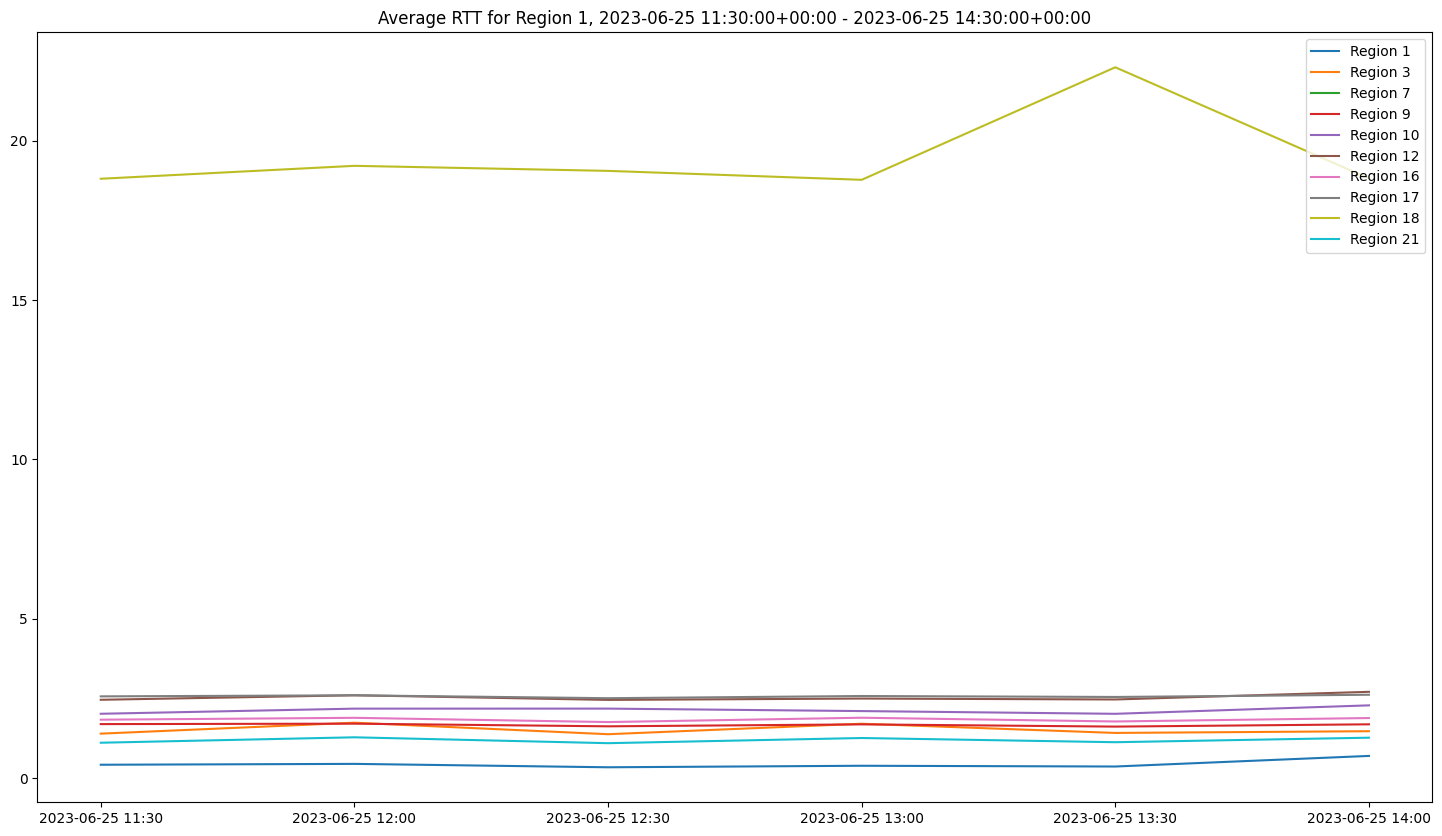

------------ANCHOR REGION 3 2023-06-25 11:30:00+00:00 - 2023-06-25 14:30:00+00:00---------------------


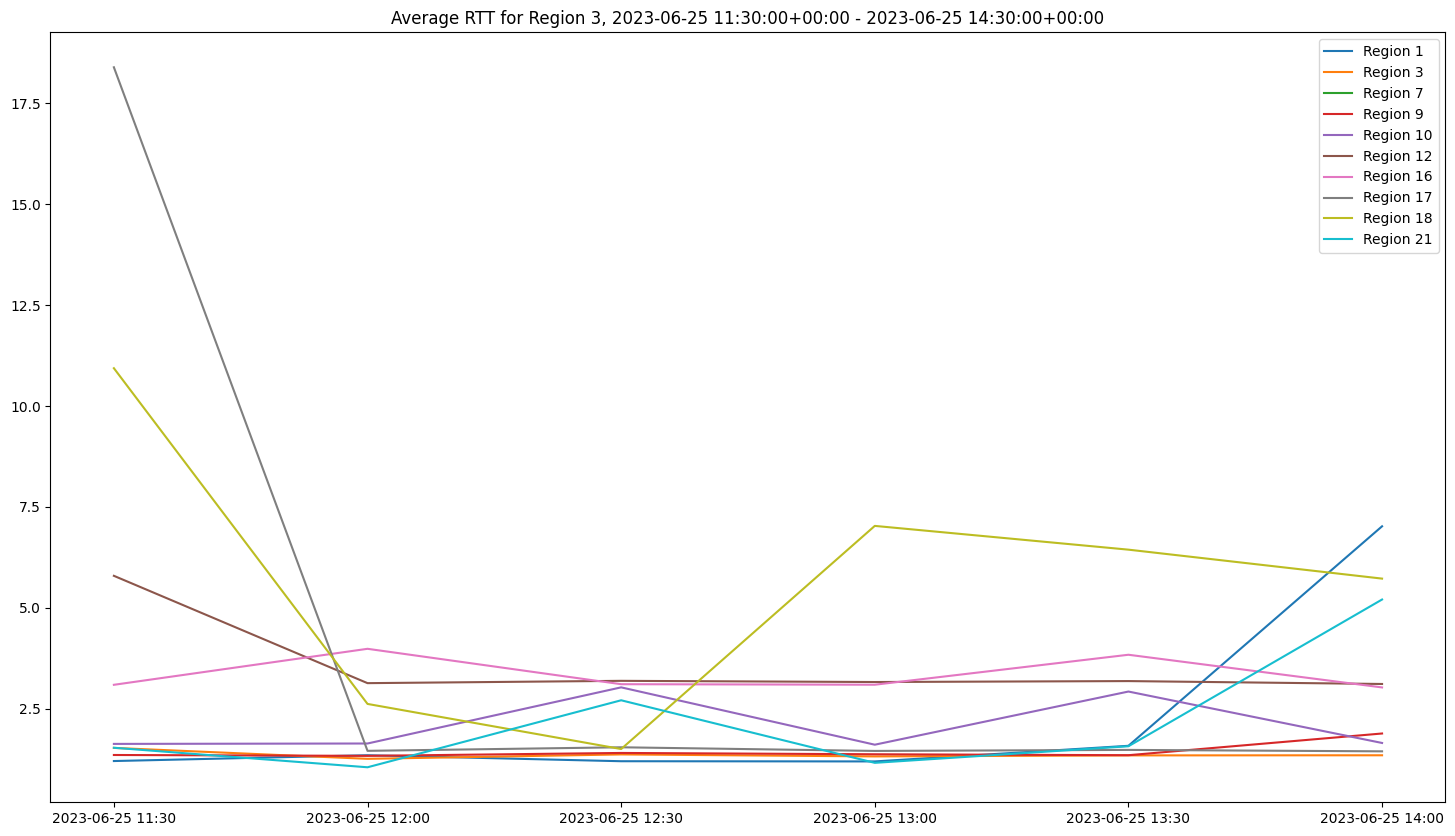

------------ANCHOR REGION 9 2023-06-25 11:30:00+00:00 - 2023-06-25 14:30:00+00:00---------------------


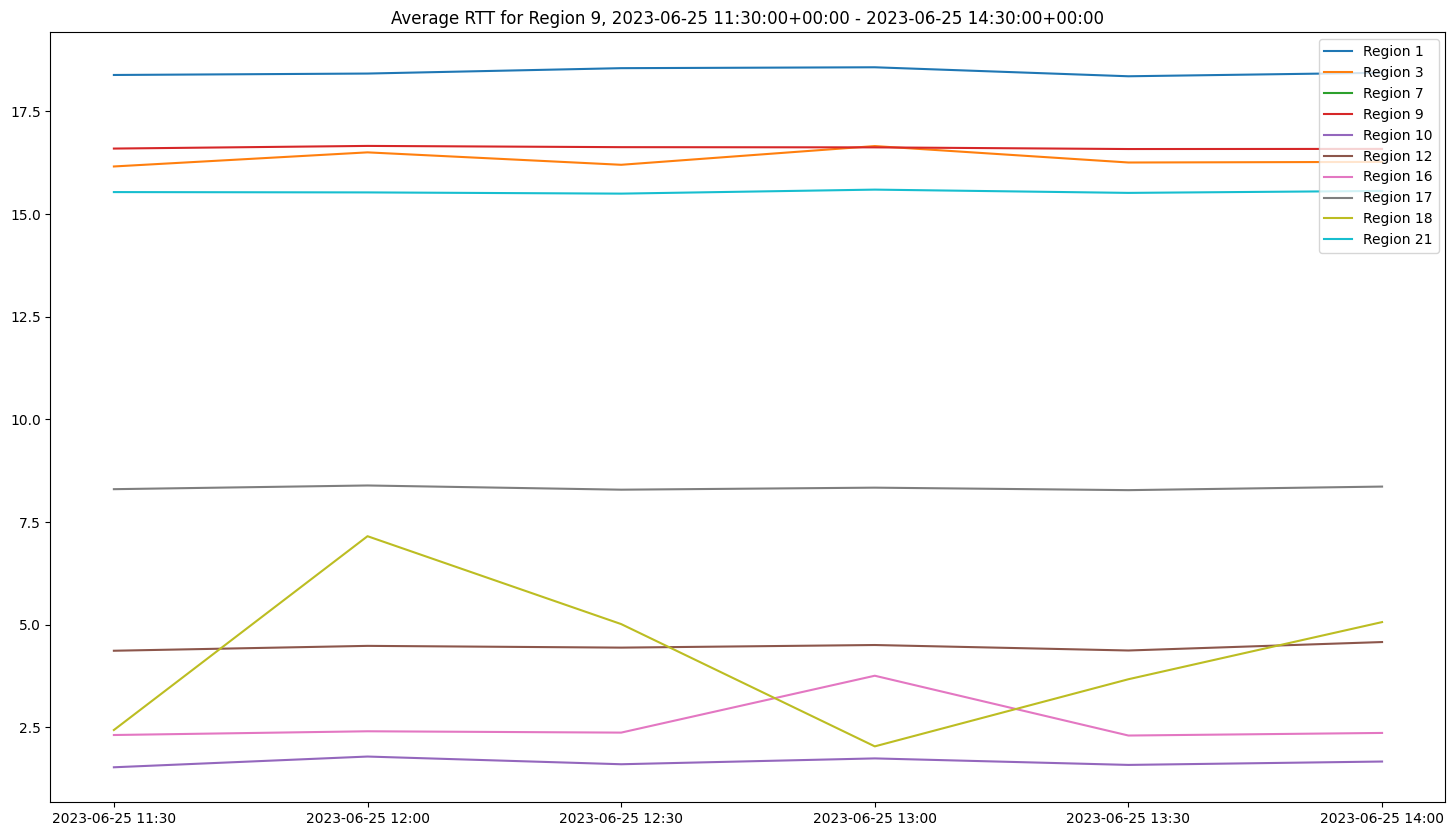

------------ANCHOR REGION 17 2023-06-25 11:30:00+00:00 - 2023-06-25 14:30:00+00:00---------------------


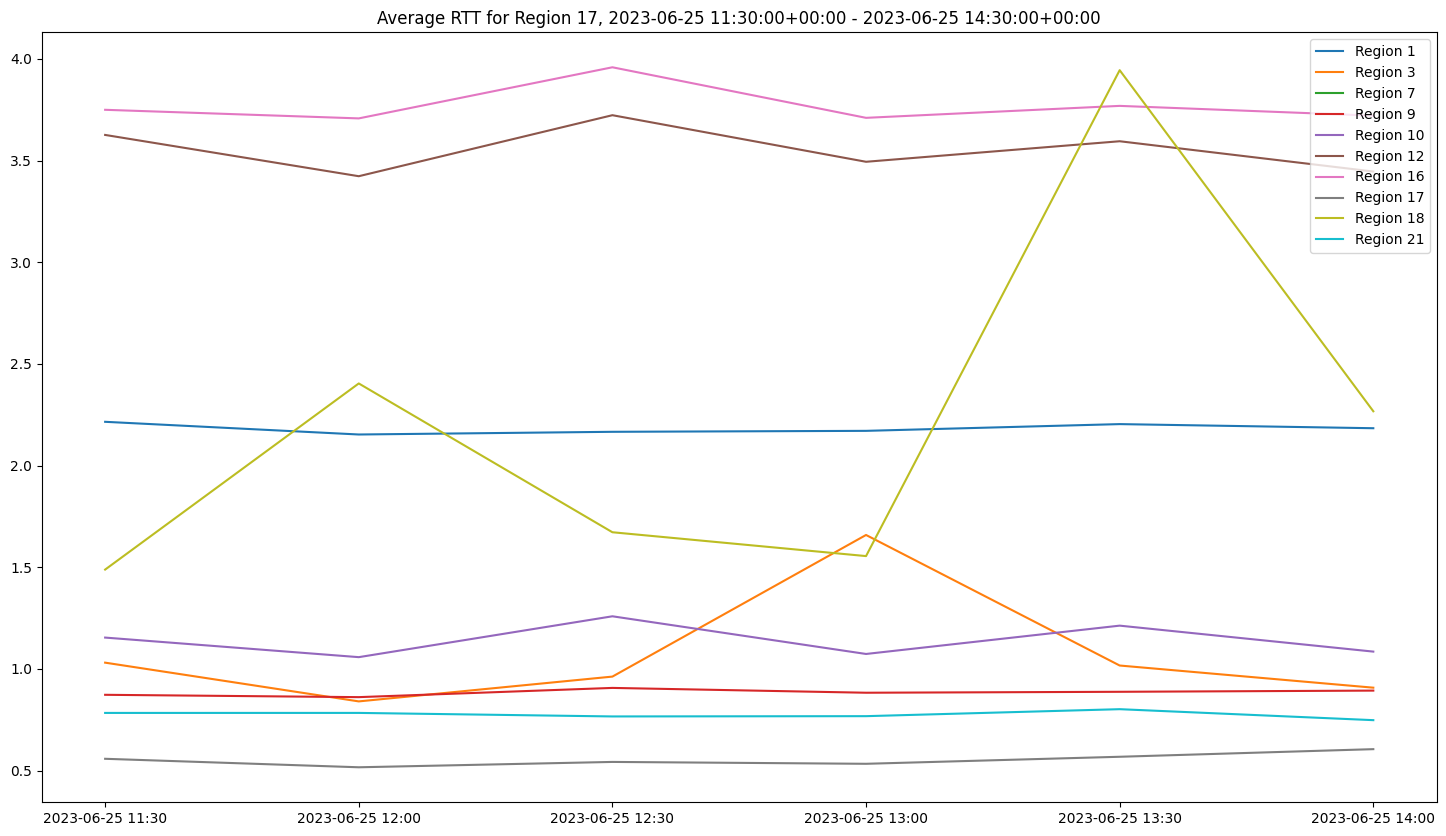

------------ANCHOR REGION 21 2023-06-25 11:30:00+00:00 - 2023-06-25 14:30:00+00:00---------------------


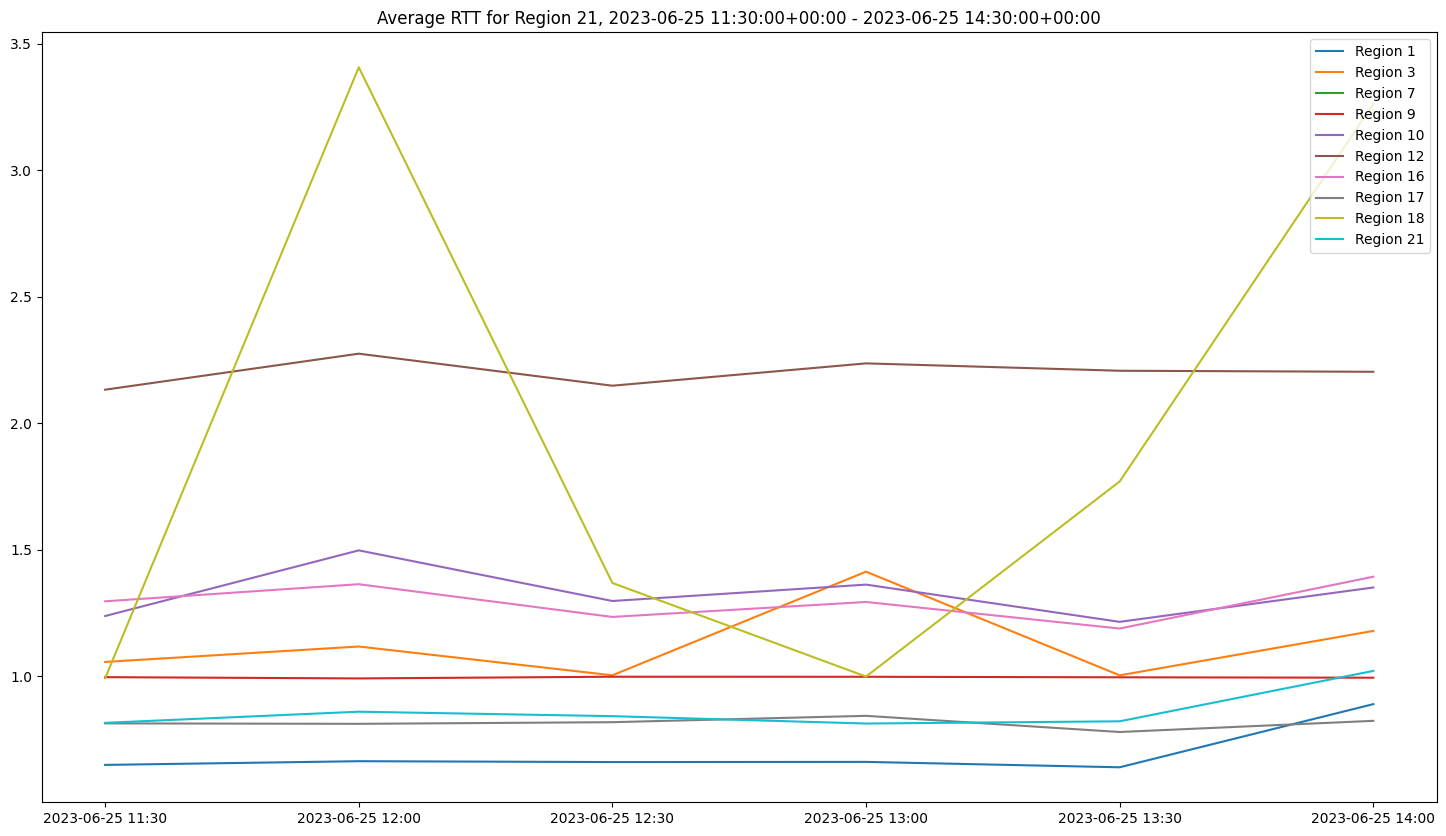

In [163]:
for region_id in regions_corresponding_to_chosen_anchors:
    time_period = "2023-06-25 11:30:00+00:00 - 2023-06-25 14:30:00+00:00"
    csv_file = f"measurement-results-individual-rtts/regionid{str(region_id)}_start2023-06-25-11-30_end2023-06-25-14-30.csv"
    df = pd.read_csv(csv_file)
    print(f"------------ANCHOR REGION {region_id} {time_period}---------------------")
    print_mean_rtts(df, region_id, time_period)

In [182]:
def print_median_rtts(df, region_id, time_period):
    df.iloc[:,1] = pd.to_datetime(df.iloc[:,1], unit="s").dt.strftime('%Y-%m-%d %H:%M')
    columns_regions_corresponding_to_probes = [f"Region {region_id}" for region_id in regions_corresponding_to_chosen_probes]
    rows_time_intervals = [f"2023-06-25 {x}" for x in  ["11:30", "12:00", "12:30", "13:00", "13:30", "14:00"]]
    result_table = pd.DataFrame(columns=columns_regions_corresponding_to_probes, index=rows_time_intervals) 
    
    for index, row in df.iterrows():
        result = row[2:].dropna()
        if len(result) > 0:
            result_table.loc[row[1], f"Region {row[0]}"] = np.median(result)

    fig, ax = plt.subplots(figsize=(18,10))

    ax.plot(result_table, label=columns_regions_corresponding_to_probes)
    plt.title(f"Median RTT for Region {region_id}, {time_period}")
    plt.legend(loc="upper right")
    plt.show()

------------ANCHOR REGION 1 2023-06-25 11:30:00+00:00 - 2023-06-25 14:30:00+00:00---------------------


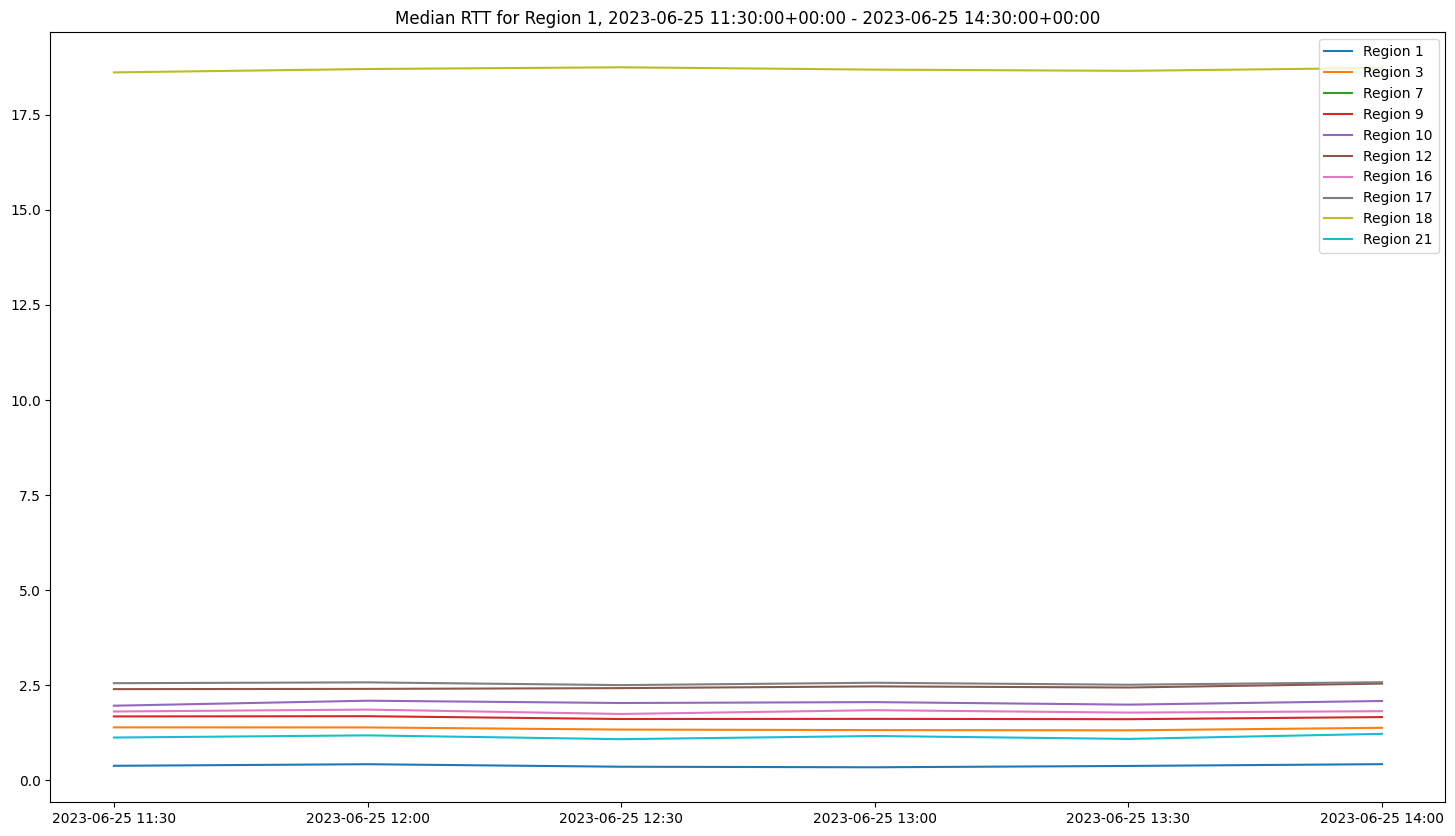

------------ANCHOR REGION 3 2023-06-25 11:30:00+00:00 - 2023-06-25 14:30:00+00:00---------------------


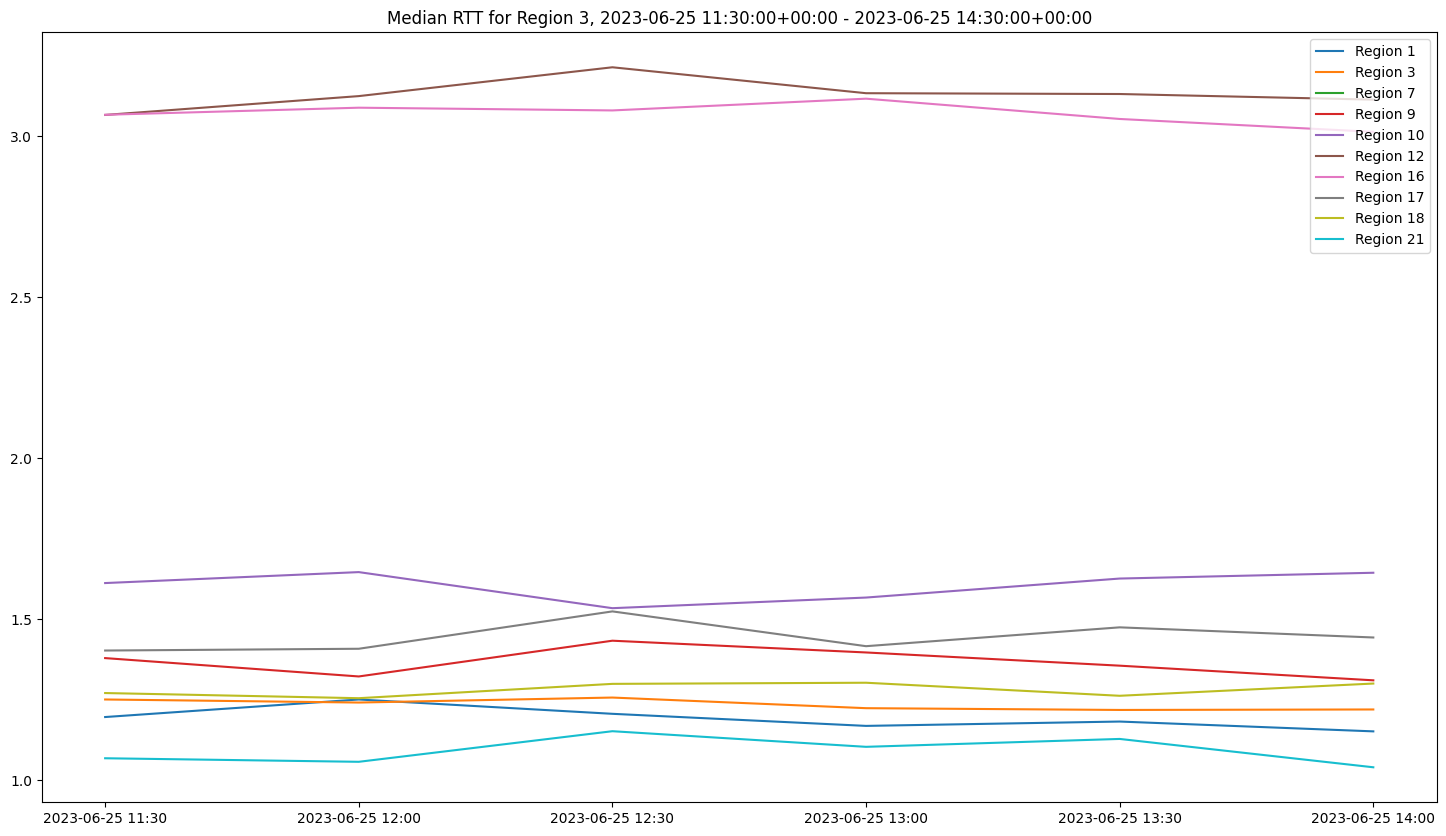

------------ANCHOR REGION 9 2023-06-25 11:30:00+00:00 - 2023-06-25 14:30:00+00:00---------------------


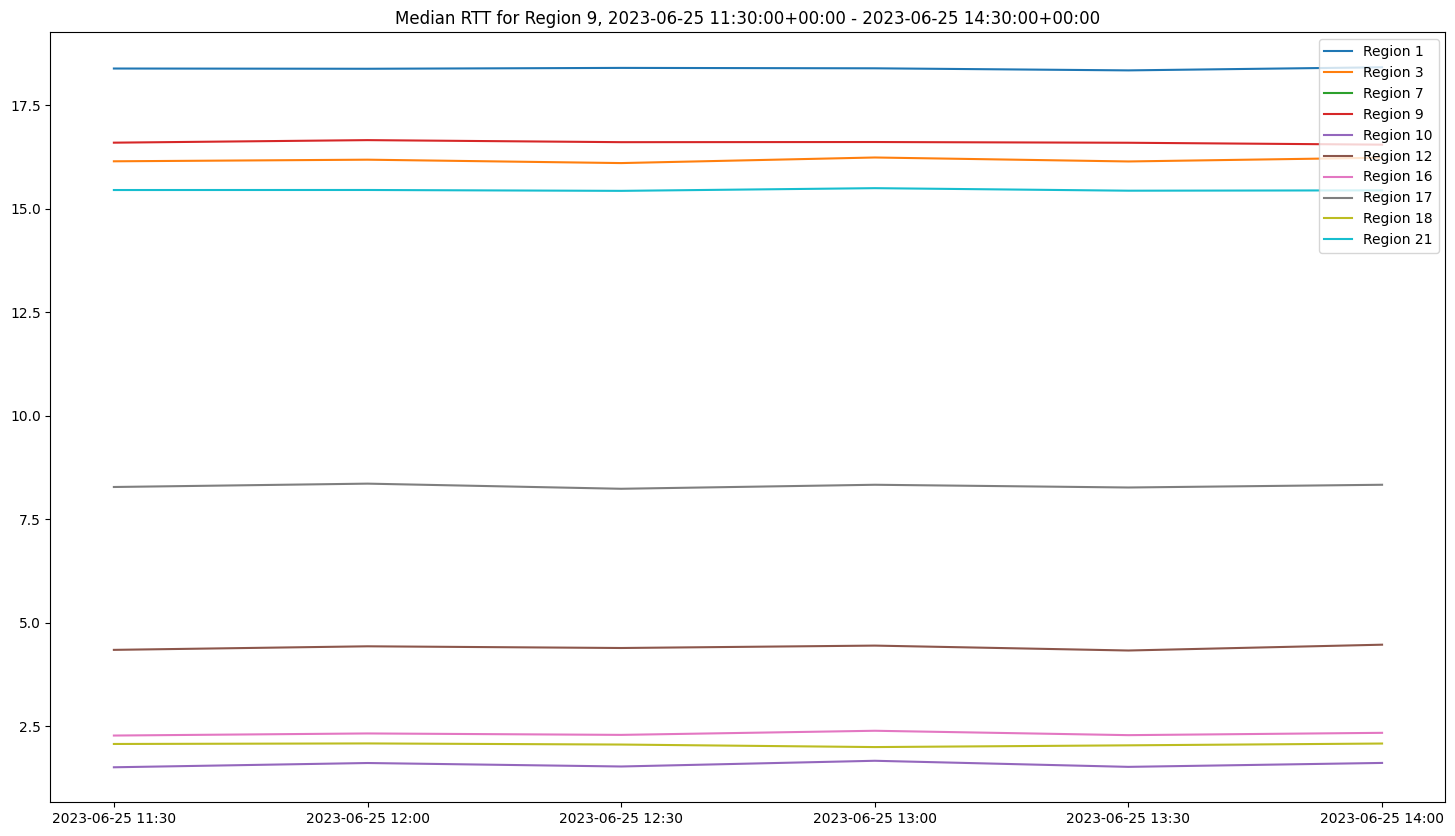

------------ANCHOR REGION 17 2023-06-25 11:30:00+00:00 - 2023-06-25 14:30:00+00:00---------------------


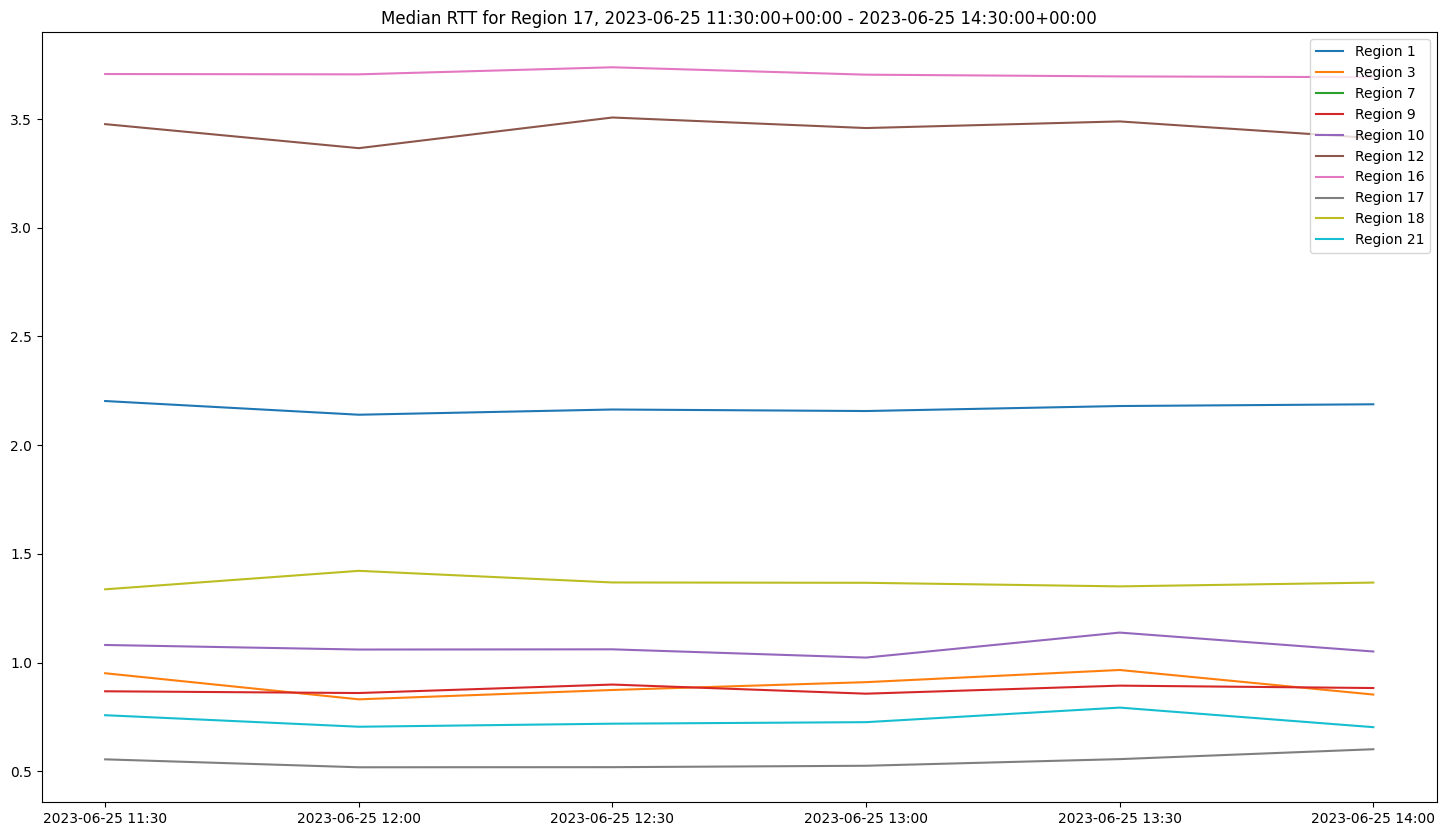

------------ANCHOR REGION 21 2023-06-25 11:30:00+00:00 - 2023-06-25 14:30:00+00:00---------------------


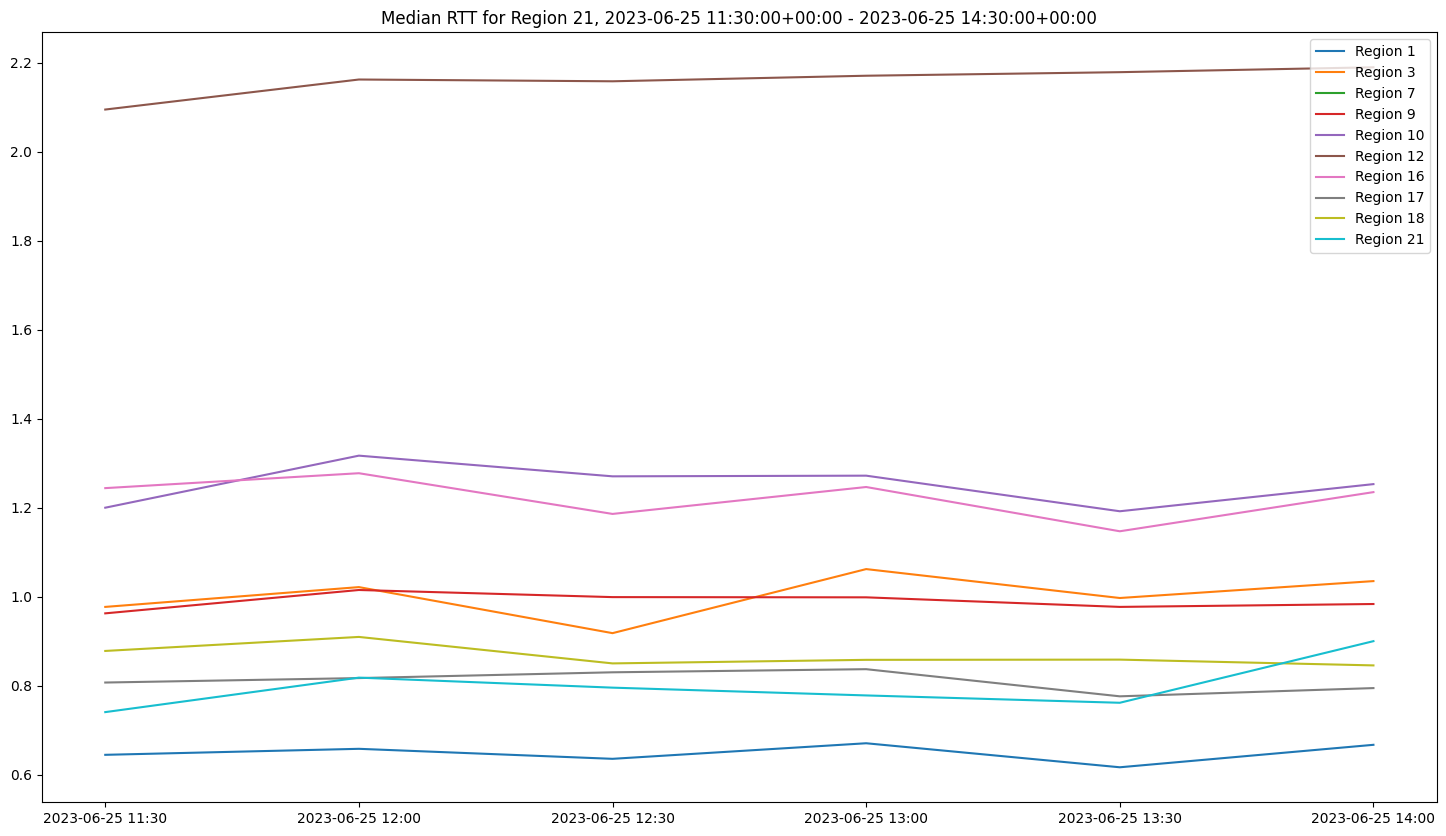

In [183]:
for region_id in regions_corresponding_to_chosen_anchors:
    time_period = "2023-06-25 11:30:00+00:00 - 2023-06-25 14:30:00+00:00"
    csv_file = f"measurement-results-individual-rtts/regionid{str(region_id)}_start2023-06-25-11-30_end2023-06-25-14-30.csv"
    df = pd.read_csv(csv_file)
    print(f"------------ANCHOR REGION {region_id} {time_period}---------------------")
    print_median_rtts(df, region_id, time_period)

In [14]:
def create_df_for_covariance_corr_calculation_within_one_region(df, max_length):
    df.drop(df.columns[[1]], axis=1, inplace=True)
    results = [np.array([region_id]) for region_id in regions_corresponding_to_chosen_probes]

    for index, row in df.iterrows():
        results[index % 10] = np.append(results[index % 10], row[1:1+max_length])

    result_df = pd.DataFrame(data=results)
    return result_df

In [15]:
def print_covariance_corr_coeff(df): 
    region_pairs = [f"1-{region_id}" for region_id in regions_corresponding_to_chosen_probes]

    covariance_table = pd.DataFrame(columns=region_pairs, index=region_pairs)
    correlation_coeff_table = pd.DataFrame(columns=region_pairs, index=region_pairs)
    
    for index, row in df.iterrows():
        rtt_values_1 = row[1:]
        region_id_1 = int(row[0])
        for j in range(index, 10):
            rtt_values_2 = df.iloc[j, 1:]
            region_id_2 = int(df.iloc[j, 0])
            if region_id_1 == region_id_2:
                covariance = "o"
                correlation_coeff = "o"
            elif region_id_1 == 7 or region_id_2 == 7:
                covariance = "x"
                correlation_coeff = "x"
            else:
                covariance = round(np.cov(rtt_values_1, rtt_values_2)[0][1], 3)
                correlation_coeff = round(np.corrcoef(rtt_values_1, rtt_values_2)[0][1], 3)
            covariance_table.loc[f"1-{region_id_1}", f"1-{region_id_2}"] = covariance
            correlation_coeff_table.loc[f"1-{region_id_1}", f"1-{region_id_2}"] = correlation_coeff

    print("Covariance: ")
    display(covariance_table)
    print("Correlation coefficient: ")
    display(correlation_coeff_table)

In [16]:
# Calculate based on the length of the smallest RTT array (18)
for region_id in regions_corresponding_to_chosen_anchors:
    time_period = "2023-06-25 11:30:00+00:00 - 2023-06-25 14:30:00+00:00"
    csv_file = f"measurement-results-individual-rtts/regionid{str(region_id)}_start2023-06-25-11-30_end2023-06-25-14-30.csv"
    df = pd.read_csv(csv_file)
    print(f"------------ANCHOR REGION {region_id} {time_period}---------------------")
    result_df = create_df_for_covariance_corr_calculation_within_one_region(df, 18)
    print_covariance_corr_coeff(result_df)

------------ANCHOR REGION 1 2023-06-25 11:30:00+00:00 - 2023-06-25 14:30:00+00:00---------------------


Covariance: 


,1-1,1-3,1-7,1-9,1-10,1-12,1-16,1-17,1-18,1-21
1-1,o,0.031,x,0.008,0.025,0.026,0.01,0.02,-0.034,0.018
1-3,NaN,o,x,0.035,0.096,0.085,0.062,0.039,0.256,0.076
1-7,NaN,NaN,o,x,x,x,x,x,x,x
1-9,NaN,NaN,NaN,o,0.021,0.024,0.015,0.01,-0.026,0.02
1-10,NaN,NaN,NaN,NaN,o,0.074,0.038,0.019,0.022,0.035
1-12,NaN,NaN,NaN,NaN,NaN,o,0.033,0.039,-0.062,0.037
1-16,NaN,NaN,NaN,NaN,NaN,NaN,o,0.018,-0.12,0.034
1-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o,0.007,0.023
1-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o,-0.018
1-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o


Correlation coefficient: 


,1-1,1-3,1-7,1-9,1-10,1-12,1-16,1-17,1-18,1-21
1-1,o,0.128,x,0.175,0.193,0.186,0.136,0.353,-0.015,0.168
1-3,NaN,o,x,0.39,0.386,0.322,0.438,0.358,0.059,0.372
1-7,NaN,NaN,o,x,x,x,x,x,x,x
1-9,NaN,NaN,NaN,o,0.444,0.467,0.545,0.479,-0.031,0.504
1-10,NaN,NaN,NaN,NaN,o,0.525,0.509,0.331,0.01,0.323
1-12,NaN,NaN,NaN,NaN,NaN,o,0.416,0.624,-0.026,0.32
1-16,NaN,NaN,NaN,NaN,NaN,NaN,o,0.551,-0.092,0.56
1-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o,0.007,0.486
1-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o,-0.01
1-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o


------------ANCHOR REGION 3 2023-06-25 11:30:00+00:00 - 2023-06-25 14:30:00+00:00---------------------
Covariance: 


,1-1,1-3,1-7,1-9,1-10,1-12,1-16,1-17,1-18,1-21
1-1,o,-0.062,x,NaN,-0.421,-0.548,-0.169,-3.79,-5.863,NaN
1-3,NaN,o,x,NaN,0.138,-0.052,0.04,0.073,1.645,NaN
1-7,NaN,NaN,o,x,x,x,x,x,x,x
1-9,NaN,NaN,NaN,o,NaN,NaN,NaN,NaN,NaN,NaN
1-10,NaN,NaN,NaN,NaN,o,-0.111,-0.111,-1.152,-1.347,NaN
1-12,NaN,NaN,NaN,NaN,NaN,o,-0.16,-1.533,-2.662,NaN
1-16,NaN,NaN,NaN,NaN,NaN,NaN,o,-1.302,-1.644,NaN
1-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o,-20.606,NaN
1-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o,NaN
1-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o


Correlation coefficient: 


,1-1,1-3,1-7,1-9,1-10,1-12,1-16,1-17,1-18,1-21
1-1,o,-0.012,x,NaN,-0.014,-0.009,-0.007,-0.009,-0.032,NaN
1-3,NaN,o,x,NaN,0.092,-0.017,0.032,0.004,0.185,NaN
1-7,NaN,NaN,o,x,x,x,x,x,x,x
1-9,NaN,NaN,NaN,o,NaN,NaN,NaN,NaN,NaN,NaN
1-10,NaN,NaN,NaN,NaN,o,-0.006,-0.014,-0.01,-0.024,NaN
1-12,NaN,NaN,NaN,NaN,NaN,o,-0.01,-0.006,-0.024,NaN
1-16,NaN,NaN,NaN,NaN,NaN,NaN,o,-0.013,-0.036,NaN
1-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o,-0.029,NaN
1-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o,NaN
1-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o


------------ANCHOR REGION 9 2023-06-25 11:30:00+00:00 - 2023-06-25 14:30:00+00:00---------------------
Covariance: 


,1-1,1-3,1-7,1-9,1-10,1-12,1-16,1-17,1-18,1-21
1-1,o,-0.006,x,0.003,0.014,-0.001,0.18,0.01,-0.209,0.014
1-3,NaN,o,x,0.012,0.009,0.07,-0.041,0.013,-0.402,0.059
1-7,NaN,NaN,o,x,x,x,x,x,x,x
1-9,NaN,NaN,NaN,o,0.009,0.002,0.029,0.004,-0.031,0.003
1-10,NaN,NaN,NaN,NaN,o,0.011,0.479,0.007,0.048,-0.0
1-12,NaN,NaN,NaN,NaN,NaN,o,0.131,0.002,-0.368,0.01
1-16,NaN,NaN,NaN,NaN,NaN,NaN,o,0.026,-0.933,0.028
1-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o,0.094,0.005
1-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o,-0.276
1-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o


Correlation coefficient: 


,1-1,1-3,1-7,1-9,1-10,1-12,1-16,1-17,1-18,1-21
1-1,o,-0.024,x,0.091,0.136,-0.014,0.213,0.222,-0.054,0.134
1-3,NaN,o,x,0.17,0.04,0.381,-0.021,0.127,-0.045,0.249
1-7,NaN,NaN,o,x,x,x,x,x,x,x
1-9,NaN,NaN,NaN,o,0.342,0.108,0.124,0.319,-0.029,0.117
1-10,NaN,NaN,NaN,NaN,o,0.156,0.612,0.168,0.013,-0.005
1-12,NaN,NaN,NaN,NaN,NaN,o,0.214,0.07,-0.131,0.133
1-16,NaN,NaN,NaN,NaN,NaN,NaN,o,0.075,-0.031,0.036
1-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o,0.06,0.119
1-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o,-0.077
1-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o


------------ANCHOR REGION 17 2023-06-25 11:30:00+00:00 - 2023-06-25 14:30:00+00:00---------------------
Covariance: 


,1-1,1-3,1-7,1-9,1-10,1-12,1-16,1-17,1-18,1-21
1-1,o,0.004,x,0.001,0.009,0.007,0.003,0.001,-0.017,0.003
1-3,NaN,o,x,0.003,0.002,0.01,0.019,-0.001,-0.158,-0.004
1-7,NaN,NaN,o,x,x,x,x,x,x,x
1-9,NaN,NaN,NaN,o,0.003,0.0,0.002,0.0,-0.033,-0.001
1-10,NaN,NaN,NaN,NaN,o,-0.005,0.013,0.002,-0.065,0.012
1-12,NaN,NaN,NaN,NaN,NaN,o,0.056,-0.005,-0.093,0.004
1-16,NaN,NaN,NaN,NaN,NaN,NaN,o,-0.003,-0.079,0.005
1-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o,0.098,-0.002
1-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o,-0.041
1-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o


Correlation coefficient: 


,1-1,1-3,1-7,1-9,1-10,1-12,1-16,1-17,1-18,1-21
1-1,o,0.053,x,0.11,0.4,0.235,0.109,0.097,-0.053,0.205
1-3,NaN,o,x,0.043,0.007,0.022,0.041,-0.014,-0.032,-0.02
1-7,NaN,NaN,o,x,x,x,x,x,x,x
1-9,NaN,NaN,NaN,o,0.155,0.004,0.07,0.062,-0.101,-0.09
1-10,NaN,NaN,NaN,NaN,o,-0.037,0.097,0.081,-0.047,0.206
1-12,NaN,NaN,NaN,NaN,NaN,o,0.342,-0.136,-0.052,0.055
1-16,NaN,NaN,NaN,NaN,NaN,NaN,o,-0.084,-0.042,0.066
1-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o,0.227,-0.106
1-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o,-0.049
1-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o


------------ANCHOR REGION 21 2023-06-25 11:30:00+00:00 - 2023-06-25 14:30:00+00:00---------------------
Covariance: 


,1-1,1-3,1-7,1-9,1-10,1-12,1-16,1-17,1-18,1-21
1-1,o,-0.004,x,-0.001,-0.001,-0.008,-0.009,-0.003,-0.001,0.01
1-3,NaN,o,x,0.0,0.012,0.023,0.007,0.009,0.934,0.015
1-7,NaN,NaN,o,x,x,x,x,x,x,x
1-9,NaN,NaN,NaN,o,0.003,0.002,-0.001,-0.0,-0.032,-0.0
1-10,NaN,NaN,NaN,NaN,o,0.044,0.066,0.004,-0.006,0.025
1-12,NaN,NaN,NaN,NaN,NaN,o,0.046,0.002,0.203,0.009
1-16,NaN,NaN,NaN,NaN,NaN,NaN,o,0.007,-0.008,0.034
1-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o,0.043,0.001
1-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o,-0.015
1-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o


Correlation coefficient: 


,1-1,1-3,1-7,1-9,1-10,1-12,1-16,1-17,1-18,1-21
1-1,o,-0.02,x,-0.046,-0.008,-0.096,-0.071,-0.142,-0.0,0.127
1-3,NaN,o,x,0.003,0.06,0.137,0.027,0.18,0.208,0.087
1-7,NaN,NaN,o,x,x,x,x,x,x,x
1-9,NaN,NaN,NaN,o,0.118,0.107,-0.043,-0.006,-0.064,-0.018
1-10,NaN,NaN,NaN,NaN,o,0.499,0.475,0.171,-0.003,0.279
1-12,NaN,NaN,NaN,NaN,NaN,o,0.408,0.102,0.107,0.126
1-16,NaN,NaN,NaN,NaN,NaN,NaN,o,0.211,-0.003,0.292
1-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o,0.077,0.068
1-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o,-0.007
1-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o


In [17]:
def create_df_for_covariance_corr_calculation(df, region_index, max_length, results):
    df.drop(df.columns[[1]], axis=1, inplace=True)

    for index, row in df.iterrows():
        results[index % 10 + region_index * 10] = np.append(results[index % 10 + region_index * 10], row[1:1+max_length])

In [103]:
def print_covariance_corr_coeff(df): 
    region_pairs = []
    for anchor_id in regions_corresponding_to_chosen_anchors:
        for region_id in regions_corresponding_to_chosen_probes:
            region_pairs.append(f"{anchor_id}-{region_id}")

    covariance_table = pd.DataFrame(columns=region_pairs, index=region_pairs)
    correlation_coeff_table = pd.DataFrame(columns=region_pairs, index=region_pairs)

    anchor1_index = -1
    for index, row in df.iterrows():
        if index % 10 == 0:
            anchor1_index += 1
        rtt_values_1 = row[1:]
        region_id_1 = int(row[0])
        anchor2_index = anchor1_index
        first_loop = True
        for j in range(index, len(df)):
            if not first_loop and j % 10 == 0:
                anchor2_index += 1
            rtt_values_2 = df.iloc[j, 1:]
            region_id_2 = int(df.iloc[j, 0])
            if anchor1_index == anchor2_index and region_id_1 == region_id_2:
                covariance = "o"
                correlation_coeff = "o"
            elif region_id_1 == 7 or region_id_2 == 7:
                covariance = "x"
                correlation_coeff = "x"
            else:
                covariance = round(np.cov(rtt_values_1, rtt_values_2)[0][1], 3)
                correlation_coeff = round(np.corrcoef(rtt_values_1, rtt_values_2)[0][1], 3)
            covariance_table.loc[f"{regions_corresponding_to_chosen_anchors[anchor1_index]}-{region_id_1}", f"{regions_corresponding_to_chosen_anchors[anchor2_index]}-{region_id_2}"] = covariance
            correlation_coeff_table.loc[f"{regions_corresponding_to_chosen_anchors[anchor1_index]}-{region_id_1}", f"{regions_corresponding_to_chosen_anchors[anchor2_index]}-{region_id_2}"] = correlation_coeff
            first_loop = False

    pd.set_option('display.max_columns', 50)
    pd.set_option('display.max_rows', 50)

    print("Covariance: ")
    display(covariance_table)
    print("Correlation coefficient: ")
    display(correlation_coeff_table)

In [26]:
# Calculate based on the length of the smallest RTT array (18)

results = []

for anchor_id in regions_corresponding_to_chosen_anchors:
    for region_id in regions_corresponding_to_chosen_probes:
        results.append(np.array([region_id]))

for region_index, region_id in enumerate(regions_corresponding_to_chosen_anchors):
    time_period = "2023-06-25 11:30:00+00:00 - 2023-06-25 14:30:00+00:00"
    csv_file = f"measurement-results-individual-rtts/regionid{str(region_id)}_start2023-06-25-11-30_end2023-06-25-14-30.csv"
    df = pd.read_csv(csv_file)
    create_df_for_covariance_corr_calculation(df, region_index, 18, results)

In [104]:
result_df = pd.DataFrame(data=results)
print_covariance_corr_coeff(result_df)

Covariance: 


,1-1,1-3,1-7,1-9,1-10,1-12,1-16,1-17,1-18,1-21,3-1,3-3,3-7,3-9,3-10,3-12,3-16,3-17,3-18,3-21,9-1,9-3,9-7,9-9,9-10,9-12,9-16,9-17,9-18,9-21,17-1,17-3,17-7,17-9,17-10,17-12,17-16,17-17,17-18,17-21,21-1,21-3,21-7,21-9,21-10,21-12,21-16,21-17,21-18,21-21
1-1,o,0.031,x,0.008,0.025,0.026,0.01,0.02,-0.034,0.018,0.225,-0.019,x,NaN,-0.044,-0.064,-0.046,-0.756,-0.337,NaN,-0.002,0.006,x,-0.004,-0.011,0.014,-0.043,0.006,-0.154,0.026,0.002,-0.025,x,0.001,-0.006,-0.013,-0.004,-0.003,-0.078,0.01,0.003,-0.0,x,0.004,0.016,0.009,0.028,0.0,0.021,0.011
1-3,NaN,o,x,0.035,0.096,0.085,0.062,0.039,0.256,0.076,0.302,-0.043,x,NaN,-0.132,-0.063,-0.088,-1.335,-0.718,NaN,-0.018,-0.058,x,-0.003,-0.015,-0.023,-0.125,-0.003,-0.402,-0.025,0.004,-0.066,x,0.005,-0.011,-0.005,-0.0,0.003,-0.076,-0.005,-0.002,0.07,x,0.007,0.154,0.134,0.117,0.005,-0.101,0.029
1-7,NaN,NaN,o,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x
1-9,NaN,NaN,NaN,o,0.021,0.024,0.015,0.01,-0.026,0.02,0.05,-0.001,x,NaN,-0.011,-0.042,-0.016,0.052,-0.127,NaN,-0.007,-0.012,x,-0.0,-0.004,-0.001,-0.044,-0.001,-0.01,-0.004,0.0,-0.014,x,0.001,-0.005,0.007,-0.0,0.0,-0.029,-0.003,0.007,0.014,x,0.002,0.018,0.011,0.013,0.001,0.156,0.004
1-10,NaN,NaN,NaN,NaN,o,0.074,0.038,0.019,0.022,0.035,1.323,-0.016,x,NaN,-0.055,-0.152,0.013,-0.703,-0.92,NaN,-0.004,-0.026,x,0.003,-0.005,-0.002,-0.062,0.011,-0.029,-0.014,0.006,-0.016,x,0.005,0.019,0.029,0.024,0.002,0.049,0.002,0.001,0.039,x,0.002,0.053,0.029,0.083,0.011,0.052,0.02
1-12,NaN,NaN,NaN,NaN,NaN,o,0.033,0.039,-0.062,0.037,0.196,-0.009,x,NaN,-0.082,-0.146,0.044,-0.665,-0.874,NaN,0.009,-0.044,x,-0.0,-0.011,-0.008,-0.03,-0.001,-0.209,-0.015,0.003,-0.028,x,0.002,-0.008,-0.006,0.003,0.006,-0.092,0.005,0.001,0.043,x,0.003,0.078,0.028,0.074,0.007,0.422,0.022
1-16,NaN,NaN,NaN,NaN,NaN,NaN,o,0.018,-0.12,0.034,0.869,-0.008,x,NaN,-0.069,0.033,-0.004,-0.747,-0.36,NaN,-0.004,-0.029,x,0.001,0.002,-0.006,-0.032,-0.0,-0.057,-0.008,0.001,-0.035,x,0.003,-0.001,-0.005,-0.001,0.002,0.09,-0.003,0.004,0.012,x,0.003,0.025,0.023,0.022,0.004,0.052,0.009
1-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o,0.007,0.023,0.066,-0.007,x,NaN,-0.045,-0.029,-0.02,0.099,-0.401,NaN,0.002,-0.014,x,0.001,-0.006,-0.005,0.005,0.001,-0.178,0.004,0.001,-0.021,x,0.001,-0.002,-0.011,-0.009,0.001,0.047,0.006,0.003,0.014,x,0.003,0.027,0.015,0.017,0.002,0.08,0.006
1-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o,-0.018,-0.779,-0.107,x,NaN,0.104,-0.417,-0.155,-2.562,-2.302,NaN,-0.08,-0.111,x,0.013,-0.078,0.026,-0.305,0.045,-0.695,-0.043,0.038,0.072,x,-0.061,0.182,-0.022,0.034,-0.001,-0.435,-0.073,-0.059,-0.085,x,-0.022,0.006,-0.053,-0.09,0.012,0.865,0.161
1-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o,0.461,-0.022,x,NaN,-0.066,-0.028,-0.058,-1.172,-0.184,NaN,-0.007,0.0,x,-0.003,0.006,-0.007,-0.056,-0.002,0.277,-0.011,-0.001,-0.02,x,0.006,-0.009,-0.002,-0.001,-0.001,-0.012,-0.006,0.008,0.059,x,0.001,0.032,0.024,0.012,0.002,0.57,0.008


Correlation coefficient: 


,1-1,1-3,1-7,1-9,1-10,1-12,1-16,1-17,1-18,1-21,3-1,3-3,3-7,3-9,3-10,3-12,3-16,3-17,3-18,3-21,9-1,9-3,9-7,9-9,9-10,9-12,9-16,9-17,9-18,9-21,17-1,17-3,17-7,17-9,17-10,17-12,17-16,17-17,17-18,17-21,21-1,21-3,21-7,21-9,21-10,21-12,21-16,21-17,21-18,21-21
1-1,o,0.128,x,0.175,0.193,0.186,0.136,0.353,-0.015,0.168,0.062,-0.107,x,NaN,-0.04,-0.029,-0.051,-0.054,-0.052,NaN,-0.021,0.023,x,-0.133,-0.098,0.167,-0.047,0.123,-0.037,0.239,0.078,-0.063,x,0.046,-0.054,-0.091,-0.027,-0.086,-0.049,0.159,0.031,-0.002,x,0.155,0.14,0.09,0.187,0.01,0.008,0.112
1-3,NaN,o,x,0.39,0.386,0.322,0.438,0.358,0.059,0.372,0.043,-0.128,x,NaN,-0.063,-0.015,-0.051,-0.05,-0.058,NaN,-0.081,-0.111,x,-0.049,-0.073,-0.138,-0.072,-0.028,-0.05,-0.117,0.09,-0.087,x,0.11,-0.053,-0.019,-0.001,0.047,-0.025,-0.04,-0.009,0.162,x,0.141,0.683,0.731,0.403,0.09,-0.021,0.154
1-7,NaN,NaN,o,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x
1-9,NaN,NaN,NaN,o,0.444,0.467,0.545,0.479,-0.031,0.504,0.038,-0.015,x,NaN,-0.028,-0.052,-0.049,0.01,-0.053,NaN,-0.167,-0.118,x,-0.022,-0.099,-0.038,-0.129,-0.071,-0.007,-0.108,0.04,-0.099,x,0.134,-0.116,0.126,-0.004,0.037,-0.05,-0.129,0.186,0.174,x,0.214,0.413,0.316,0.242,0.088,0.166,0.114
1-10,NaN,NaN,NaN,NaN,o,0.525,0.509,0.331,0.01,0.323,0.357,-0.088,x,NaN,-0.049,-0.068,0.014,-0.049,-0.139,NaN,-0.034,-0.093,x,0.083,-0.047,-0.021,-0.067,0.218,-0.007,-0.127,0.216,-0.041,x,0.182,0.174,0.205,0.159,0.05,0.03,0.032,0.009,0.168,x,0.059,0.447,0.303,0.539,0.377,0.02,0.197
1-12,NaN,NaN,NaN,NaN,NaN,o,0.416,0.624,-0.026,0.32,0.05,-0.047,x,NaN,-0.07,-0.062,0.045,-0.044,-0.125,NaN,0.069,-0.147,x,-0.011,-0.091,-0.084,-0.03,-0.014,-0.047,-0.125,0.116,-0.066,x,0.084,-0.067,-0.037,0.017,0.166,-0.053,0.074,0.013,0.178,x,0.105,0.618,0.276,0.458,0.224,0.154,0.206
1-16,NaN,NaN,NaN,NaN,NaN,NaN,o,0.551,-0.092,0.56,0.413,-0.075,x,NaN,-0.11,0.026,-0.008,-0.092,-0.096,NaN,-0.06,-0.183,x,0.076,0.035,-0.127,-0.06,-0.004,-0.023,-0.125,0.101,-0.154,x,0.231,-0.016,-0.06,-0.011,0.119,0.097,-0.086,0.067,0.088,x,0.215,0.369,0.411,0.253,0.216,0.035,0.159
1-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o,0.007,0.486,0.04,-0.093,x,NaN,-0.093,-0.03,-0.049,0.016,-0.138,NaN,0.044,-0.112,x,0.069,-0.125,-0.119,0.011,0.025,-0.096,0.078,0.083,-0.12,x,0.043,-0.033,-0.179,-0.14,0.054,0.066,0.189,0.059,0.143,x,0.229,0.507,0.345,0.256,0.17,0.071,0.14
1-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o,-0.01,-0.012,-0.035,x,NaN,0.005,-0.011,-0.01,-0.01,-0.02,NaN,-0.038,-0.023,x,0.024,-0.04,0.018,-0.019,0.053,-0.01,-0.022,0.085,0.01,x,-0.134,0.094,-0.009,0.013,-0.001,-0.015,-0.063,-0.032,-0.021,x,-0.049,0.003,-0.031,-0.034,0.025,0.019,0.093
1-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,o,0.153,-0.152,x,NaN,-0.072,-0.015,-0.078,-0.101,-0.034,NaN,-0.067,0.001,x,-0.095,0.068,-0.097,-0.074,-0.04,0.08,-0.124,-0.037,-0.062,x,0.261,-0.097,-0.018,-0.01,-0.05,-0.009,-0.119,0.093,0.316,x,0.072,0.333,0.308,0.097,0.085,0.27,0.097


In [3]:
def create_df_with_time_periods_and_actual_rtts(df):
    df.iloc[:,1] = pd.to_datetime(df.iloc[:,1], unit="s").dt.strftime('%Y-%m-%d %H:%M')
    columns_regions_corresponding_to_probes = [f"Region {region_id}" for region_id in regions_corresponding_to_chosen_probes]
    rows_time_intervals = []
    for x in ["11:30", "12:00", "12:30", "13:00", "13:30", "14:00"]:
        labels = f"2023-06-25 {x}," * 18 
        rows_time_intervals += labels.split(",")[:-1]

    result_table = pd.DataFrame(columns=columns_regions_corresponding_to_probes, index=rows_time_intervals) 

    iteration = 0
    first_loop = True
    for index, row in df.iterrows():
        if not first_loop and index % 10 == 0:
            iteration += 1
        first_loop = False
        
        rtt_values = row[2:]
        for i in range(18):
            result_table.iloc[i + iteration * 18, regions_corresponding_to_chosen_probes.index(int(row[0]))] = rtt_values[i]
        
    return result_table, columns_regions_corresponding_to_probes

In [21]:
def print_rtt_values(df, region_id, time_period):
    result_table, columns_regions_corresponding_to_probes = create_df_with_time_periods_and_actual_rtts(df)
    result_table.plot(label=columns_regions_corresponding_to_probes, figsize=(18,6))
    plt.title(f"RTT values for Region {region_id}, {time_period}")
    plt.legend(loc="upper right")
    plt.show() 

------------ANCHOR REGION 1 2023-06-25 11:30:00+00:00 - 2023-06-25 14:30:00+00:00---------------------


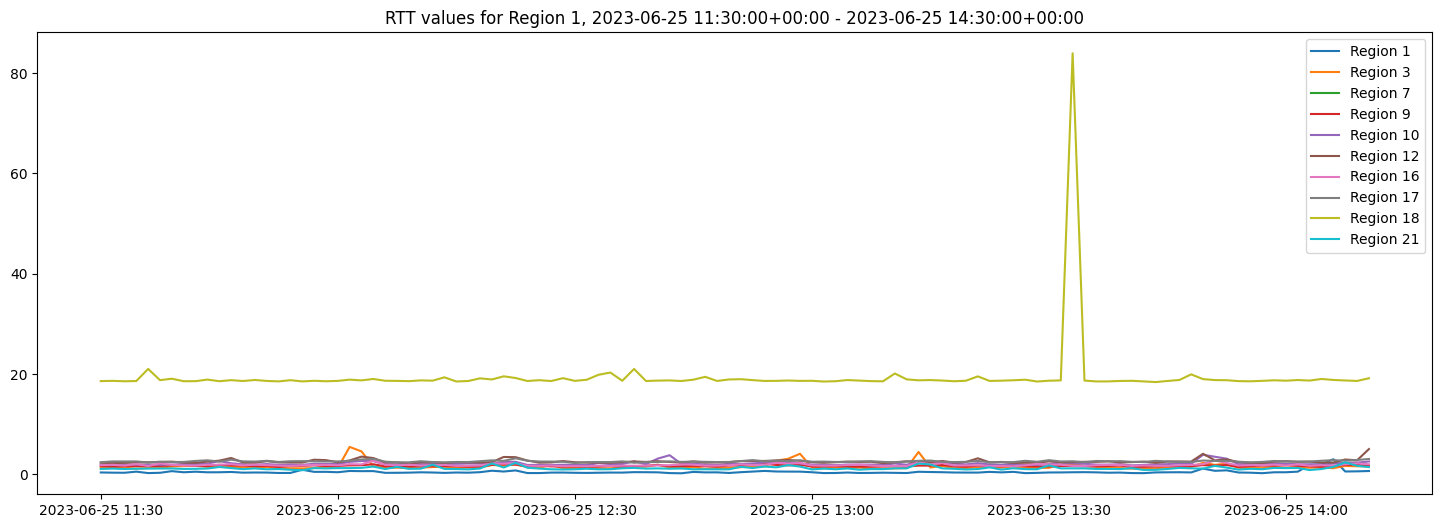

------------ANCHOR REGION 3 2023-06-25 11:30:00+00:00 - 2023-06-25 14:30:00+00:00---------------------


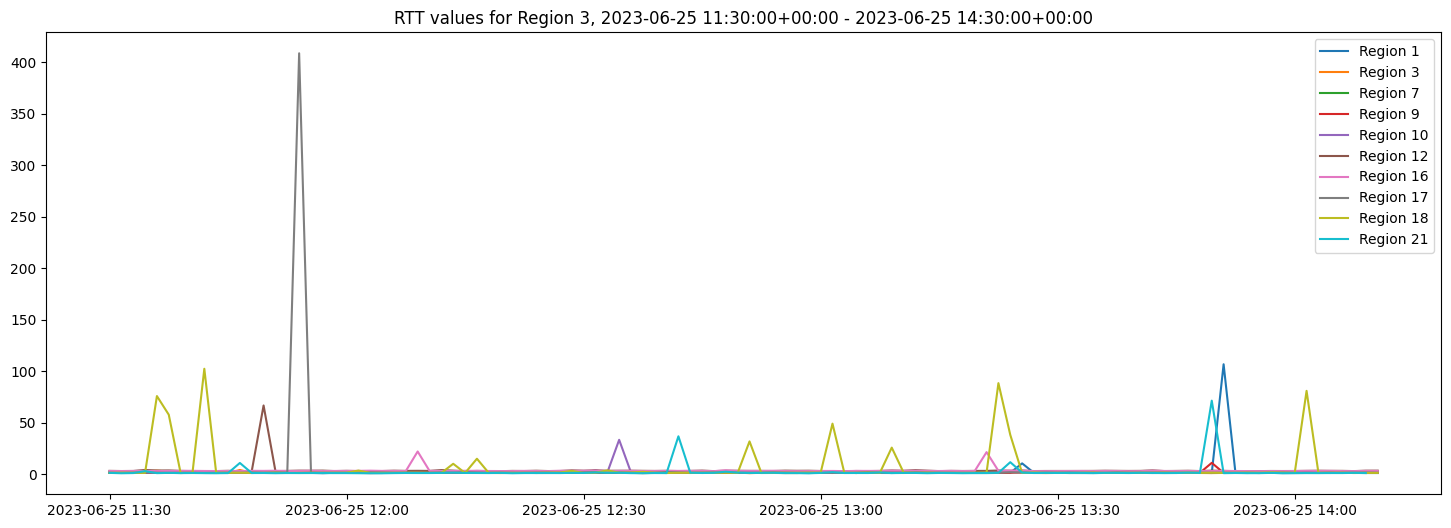

------------ANCHOR REGION 9 2023-06-25 11:30:00+00:00 - 2023-06-25 14:30:00+00:00---------------------


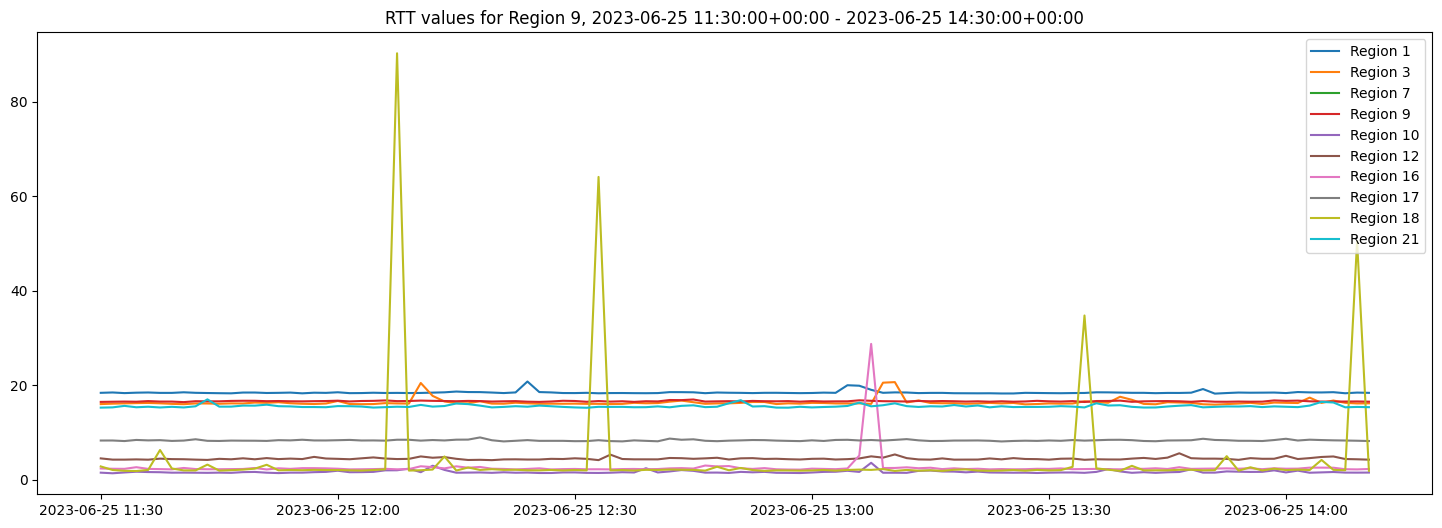

------------ANCHOR REGION 17 2023-06-25 11:30:00+00:00 - 2023-06-25 14:30:00+00:00---------------------


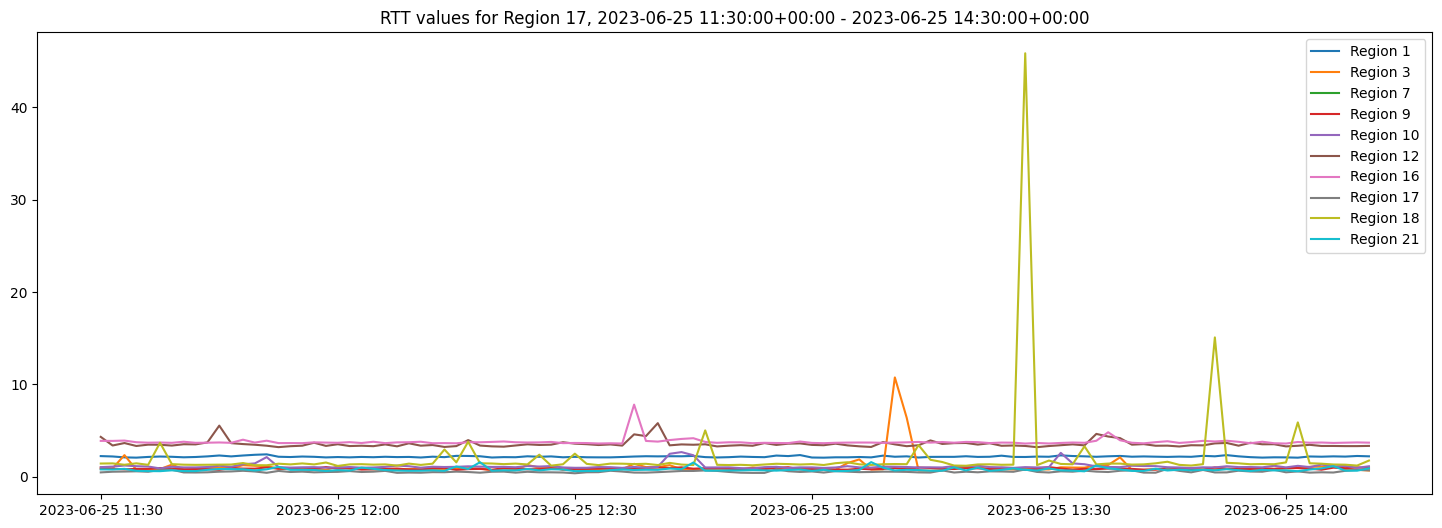

------------ANCHOR REGION 21 2023-06-25 11:30:00+00:00 - 2023-06-25 14:30:00+00:00---------------------


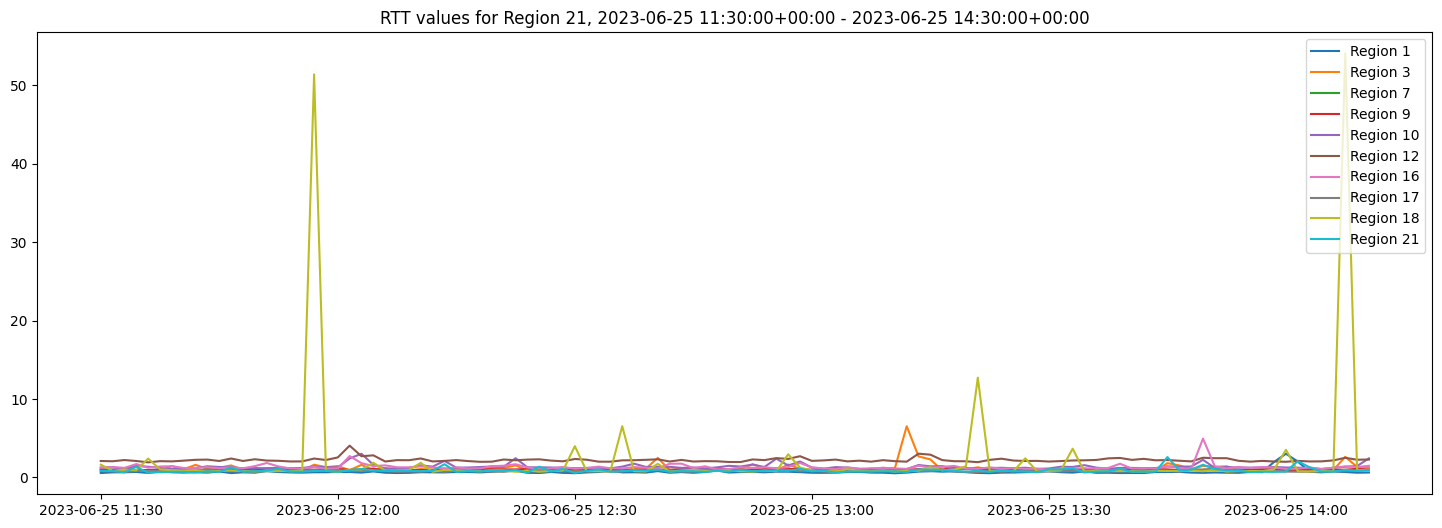

In [22]:
for region_id in regions_corresponding_to_chosen_anchors:
    time_period = "2023-06-25 11:30:00+00:00 - 2023-06-25 14:30:00+00:00"
    csv_file = f"measurement-results-individual-rtts/regionid{str(region_id)}_start2023-06-25-11-30_end2023-06-25-14-30.csv"
    df = pd.read_csv(csv_file)
    print(f"------------ANCHOR REGION {region_id} {time_period}---------------------")
    print_rtt_values(df, region_id, time_period)

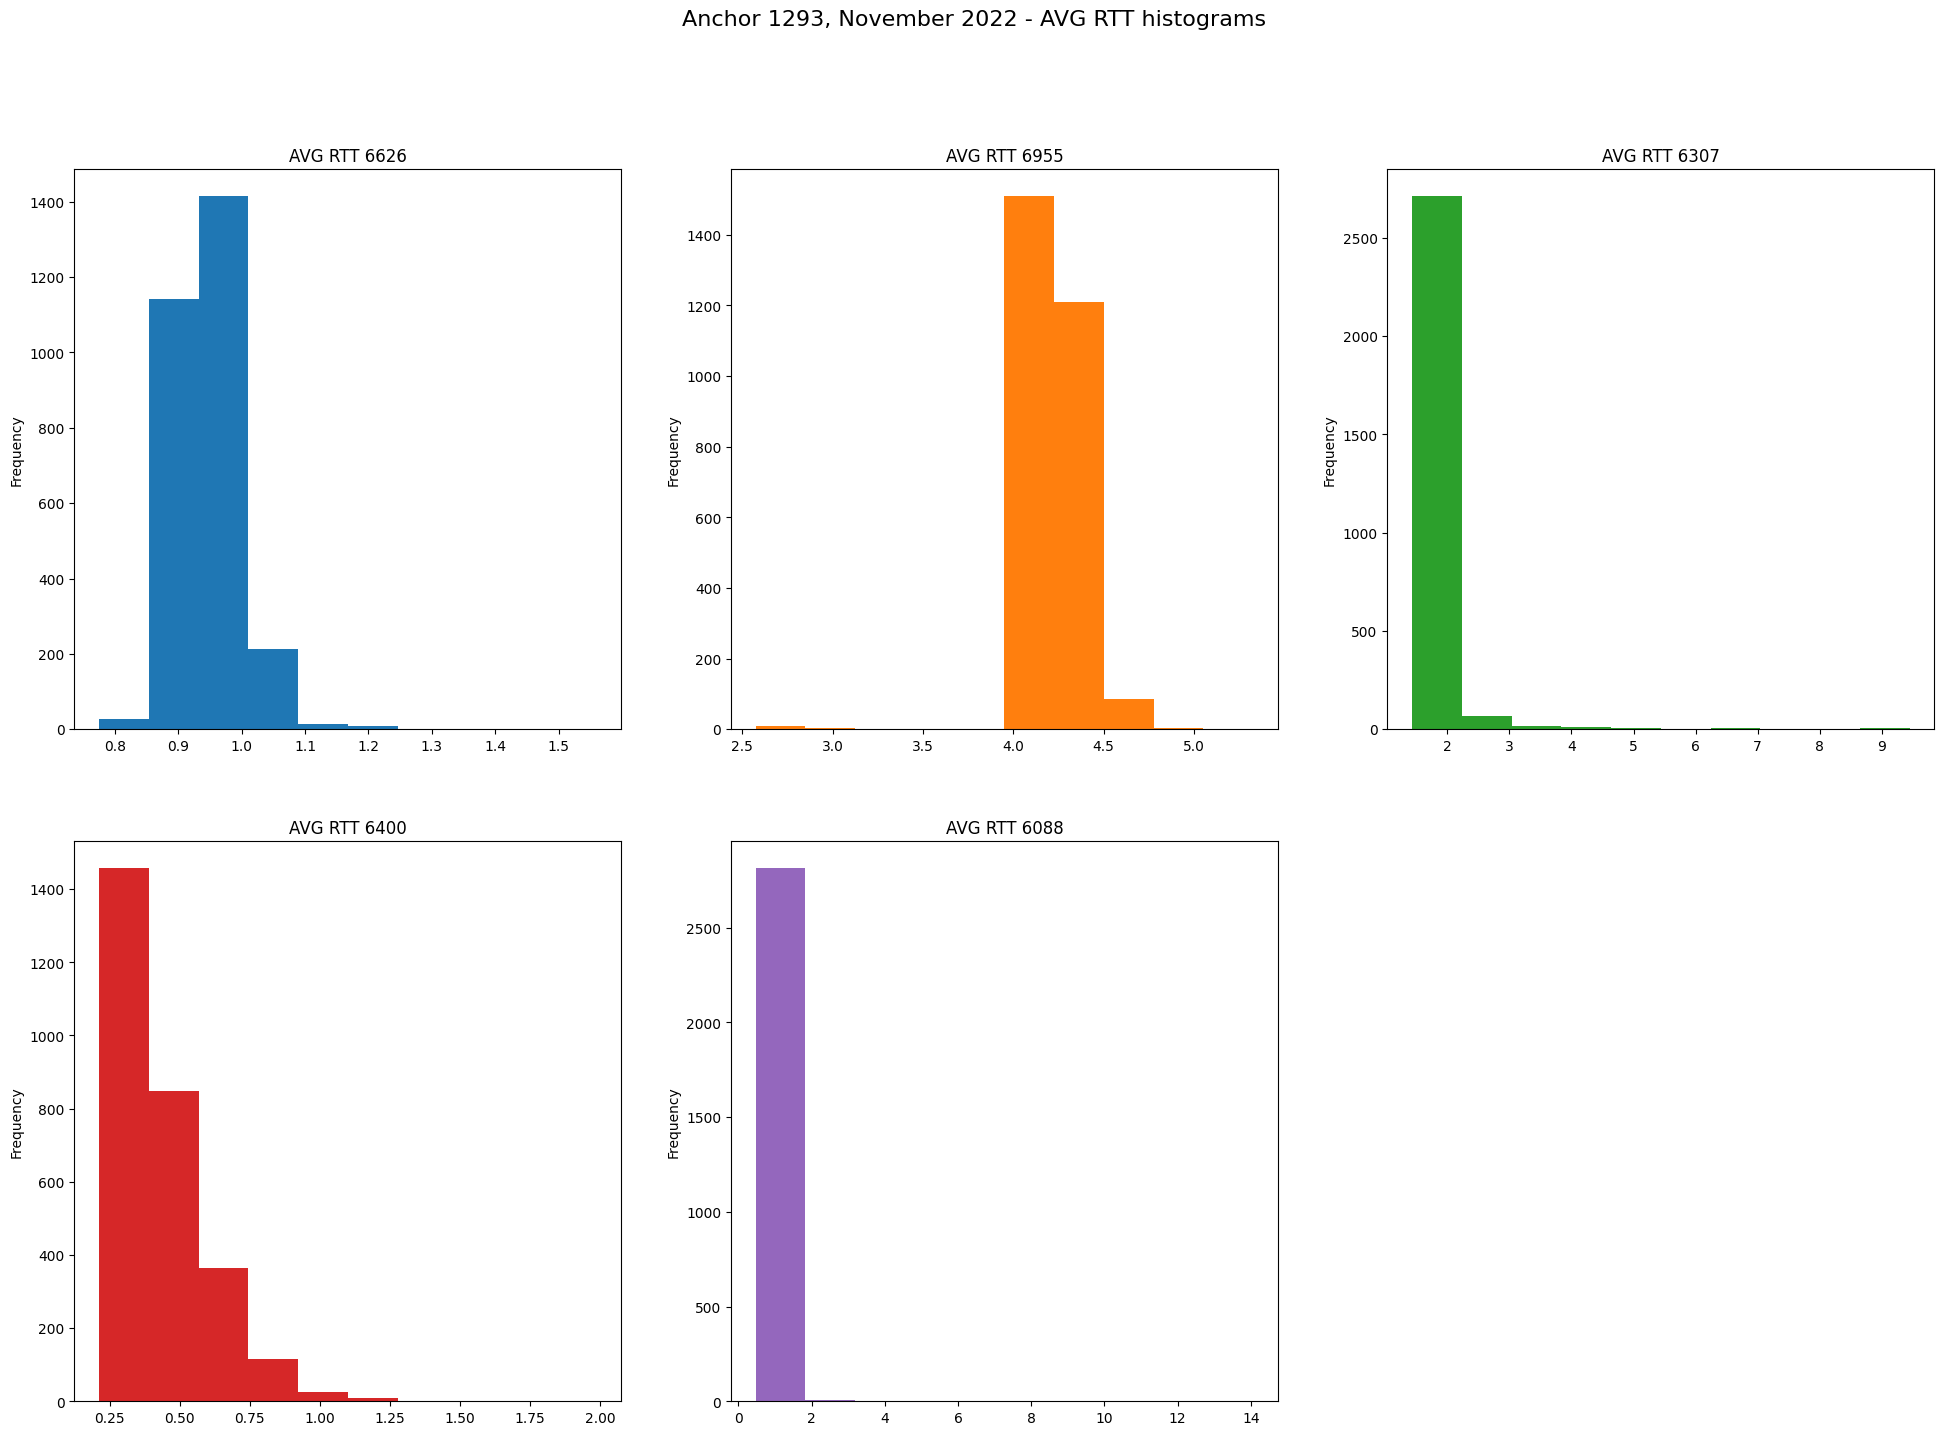

In [71]:
# Plot AVG RTT histograms

fig, ax = plt.subplots(2, 3, figsize=(24,16))
fig.delaxes(ax[1, 2])
colors = plt.rcParams["axes.prop_cycle"]()
fig.suptitle("Anchor 1293, November 2022 - AVG RTT histograms", fontsize=16)

probes = ["6626", "6955", "6307", "6400", "6088"]
index = 0
for i in range(2):
    for j in range(3):
        if i == 1 and j == 2:
            break
        c = next(colors)["color"]
        anchorid1293_start1667257200_end1669849200_df[f"RTT_AVG_{probes[index]}"].plot.hist(ax=ax[i][j], color=c)
        ax[i][j].set_title(f"AVG RTT {probes[index]}")
        index += 1

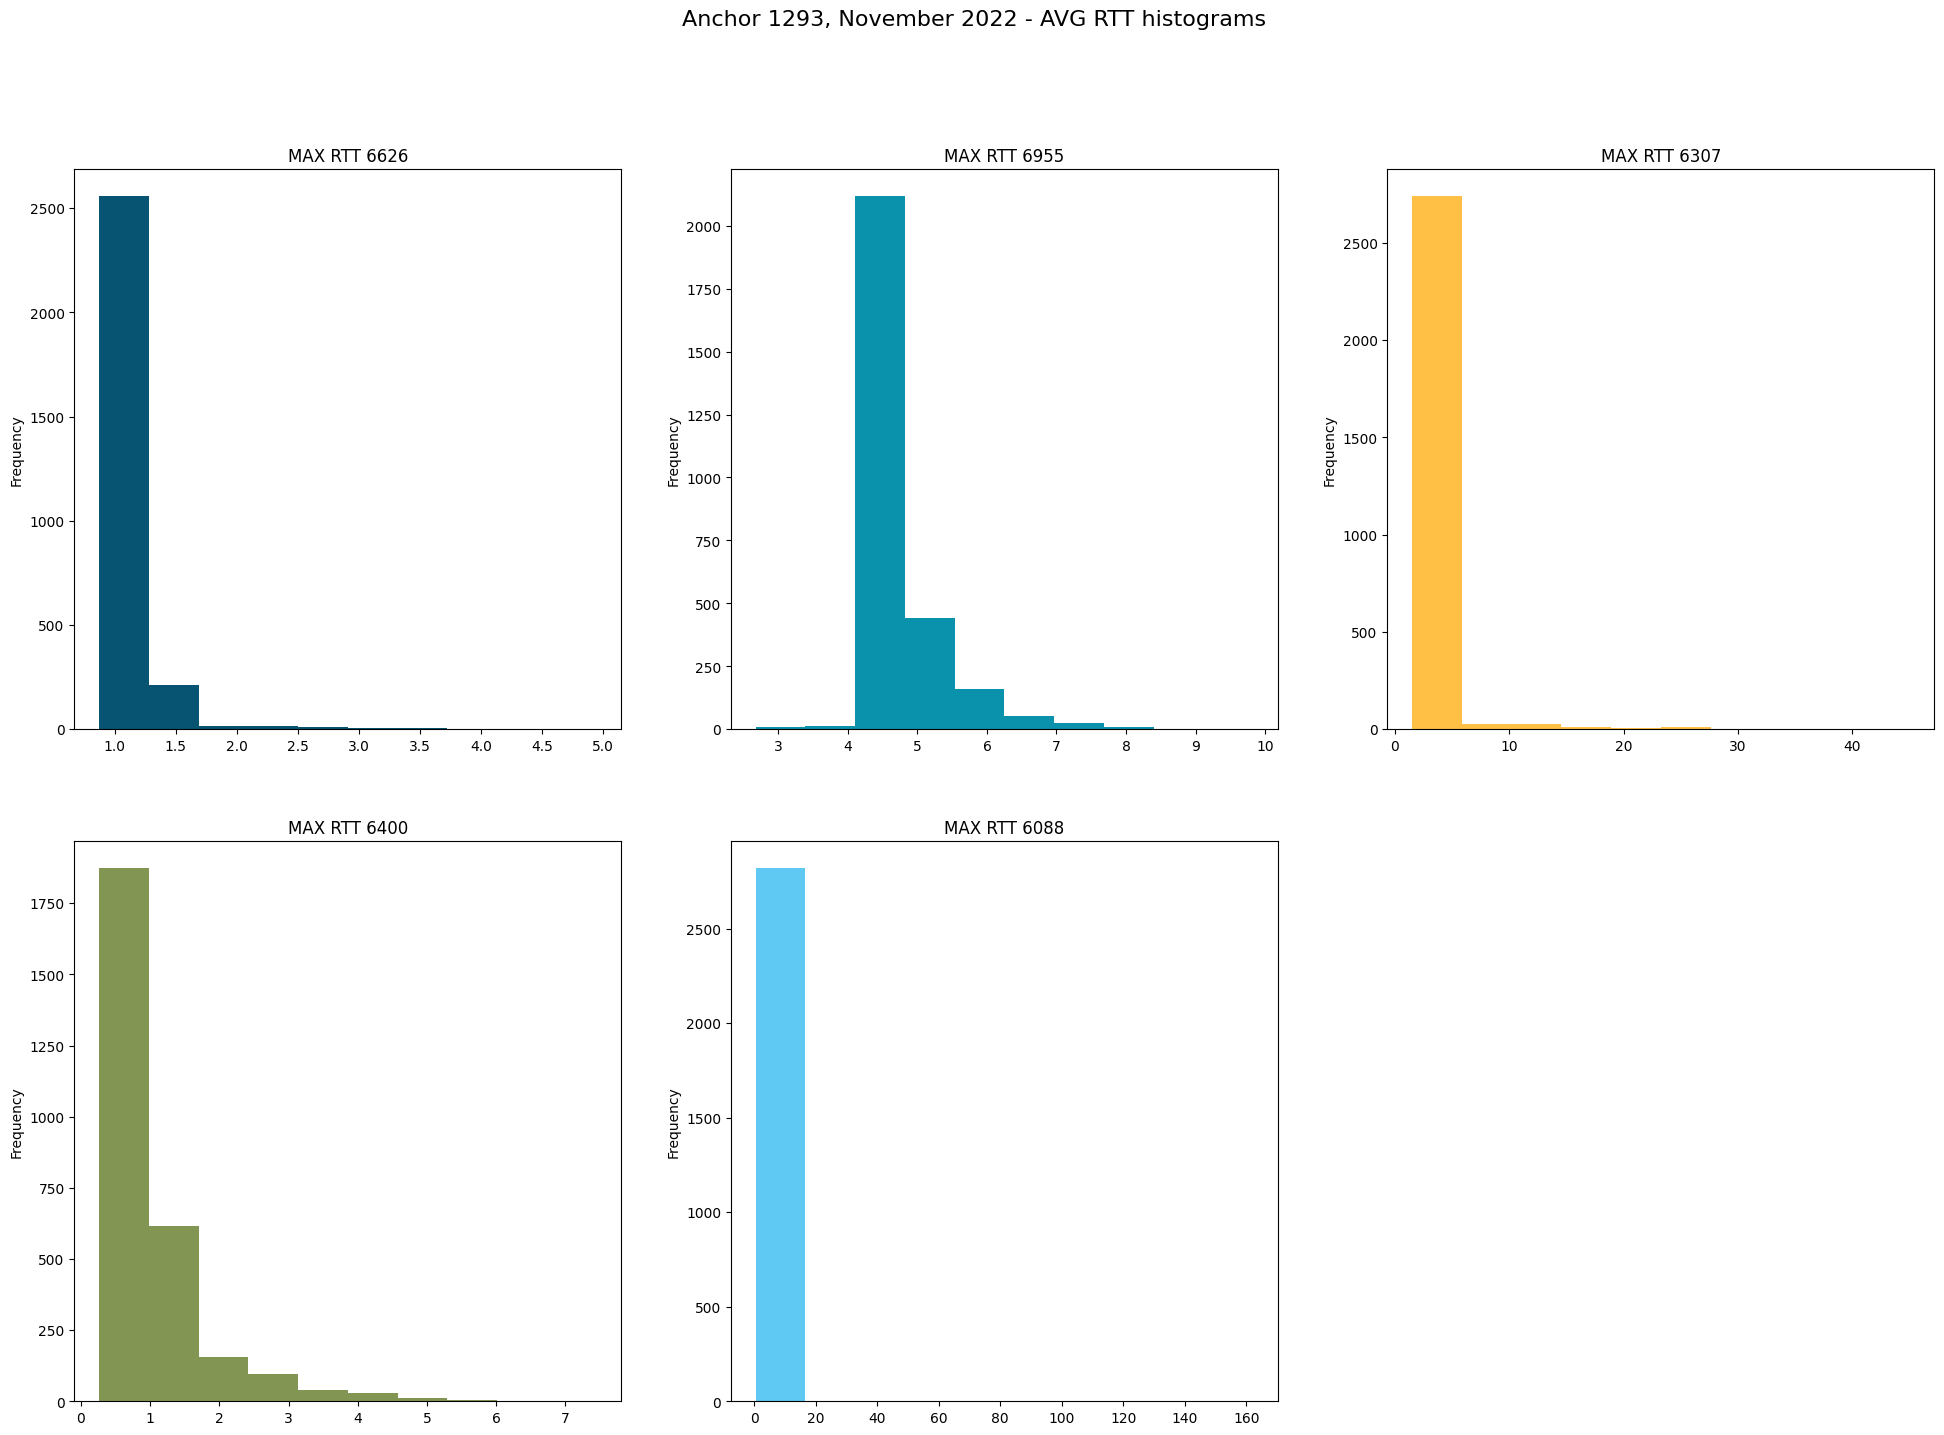

In [72]:
# Plot max RTT histograms

fig, ax = plt.subplots(2, 3, figsize=(24,16))
fig.delaxes(ax[1, 2])
colors = ["#065471", "#0a91ab", "#ffc045", "#839552", "#5fc9f3"]
fig.suptitle("Anchor 1293, November 2022 - AVG RTT histograms", fontsize=16)

probes = ["6626", "6955", "6307", "6400", "6088"]
index = 0
for i in range(2):
    for j in range(3):
        if i == 1 and j == 2:
            break
        anchorid1293_start1667257200_end1669849200_df[f"RTT_MAX_{probes[index]}"].plot.hist(ax=ax[i][j], color=colors[index])
        ax[i][j].set_title(f"MAX RTT {probes[index]}")
        index += 1

In [25]:
def histogram_plot(df, region_id, time_period):
    result_table, columns_regions_corresponding_to_probes = create_df_with_time_periods_and_actual_rtts(df)
        
    fig, ax = plt.subplots(5, 2, figsize=(24,16))
    plt.subplots_adjust(left=0.1,
                    bottom=0.2,
                    right=0.7,
                    top=0.9, 
                    hspace=0.7)
    
    colors = plt.rcParams["axes.prop_cycle"]()
    fig.suptitle(f"Region {region_id}, {time_period} - RTT histograms", fontsize=16)

    index = 0
    for i in range(5):
        for j in range(2):
            c = next(colors)["color"]
            result_table[f"Region {regions_corresponding_to_chosen_probes[index]}"].plot.hist(ax=ax[i][j], color=c)
            ax[i][j].set_title(f"RTT {regions_corresponding_to_chosen_probes[index]}")
            index += 1

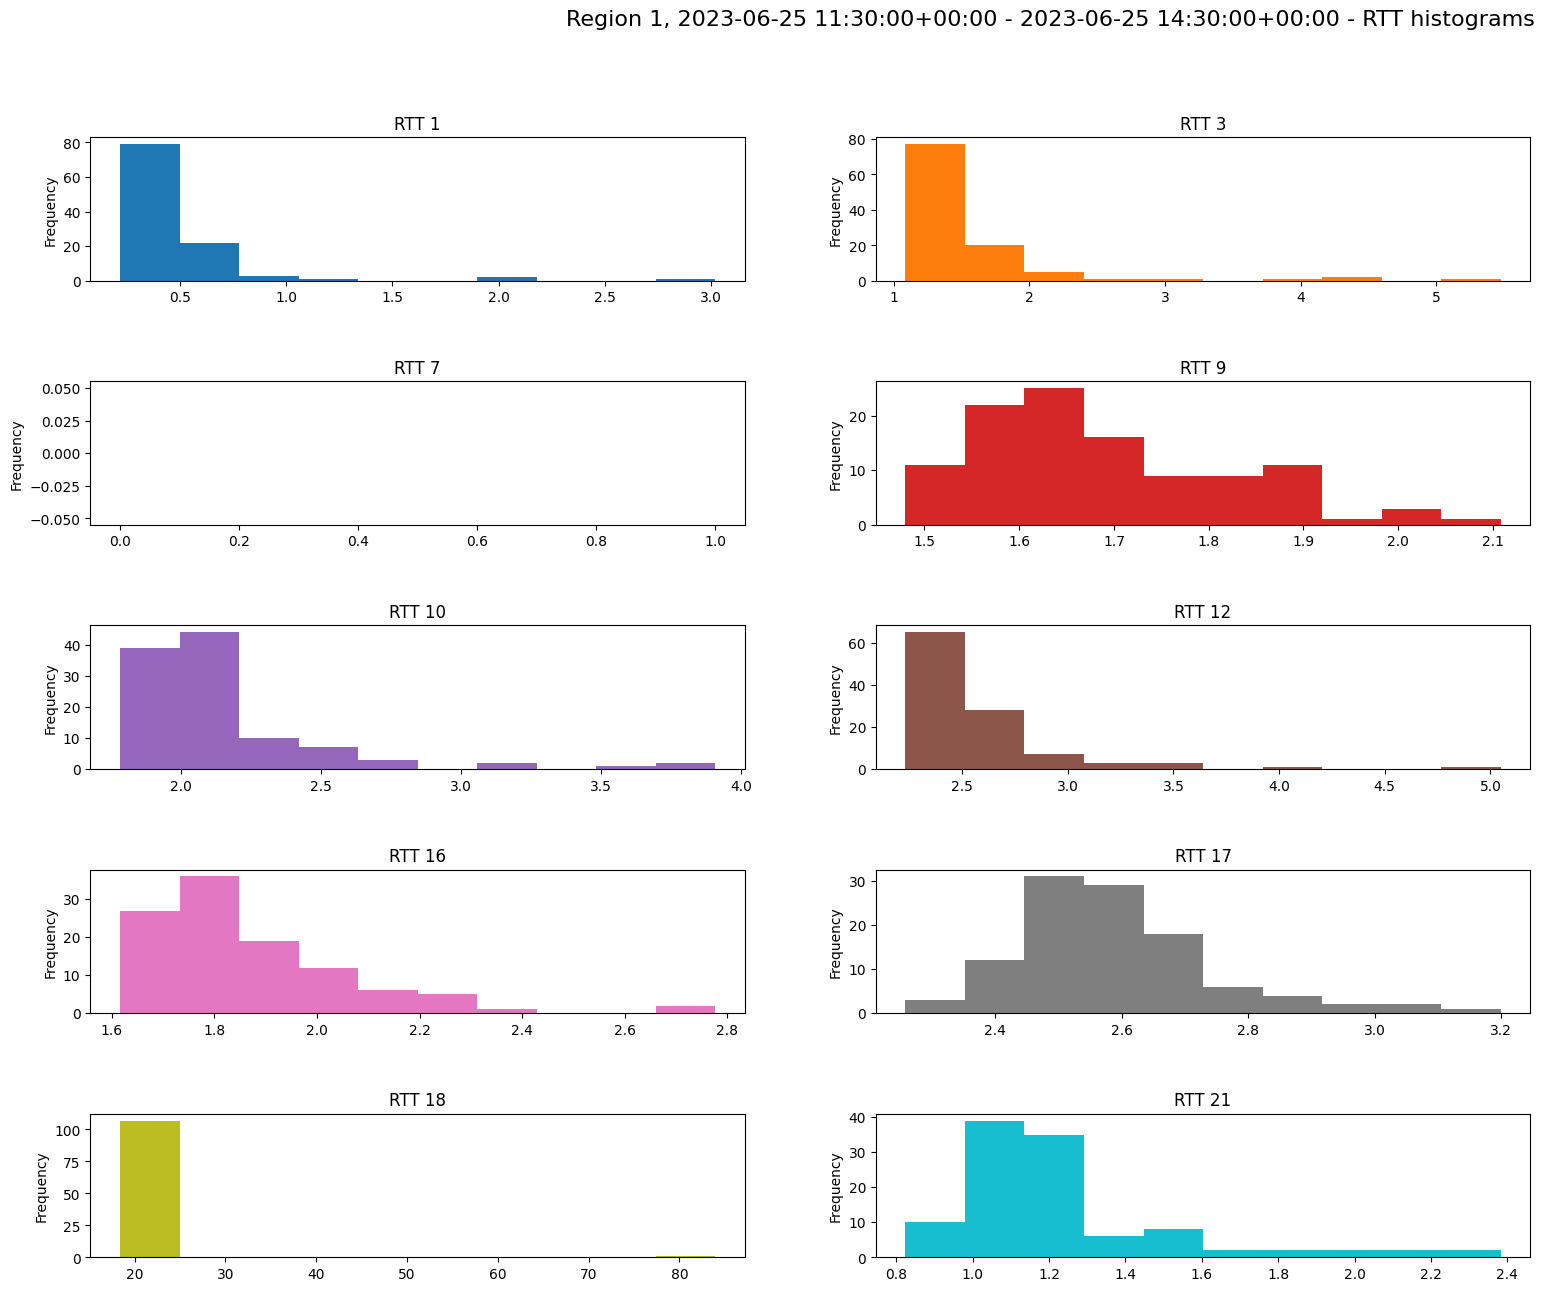

In [26]:
region_id = 1
time_period = "2023-06-25 11:30:00+00:00 - 2023-06-25 14:30:00+00:00"
csv_file = f"measurement-results-individual-rtts/regionid{str(region_id)}_start2023-06-25-11-30_end2023-06-25-14-30.csv"
df = pd.read_csv(csv_file)
histogram_plot(df, region_id, time_period)